In [1]:
import os
import copy
import numpy as np
import pandas as pd
from astropy import units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from lsst.daf.persistence import Butler, NoResults
import syseng_throughputs as st
from rubin_sim.photUtils import Bandpass, Sed, PhotometricParameters, calcM5
from rubin_sim.site_models import SeeingModel
from rubin_sim.utils import angularSeparation
from lsst.geom import Point2D, Point2I
from lsst.afw.cameraGeom import FIELD_ANGLE, PIXELS
from lsst.obs.lsst.lsstCamMapper import LsstCamMapper

In [2]:
DATADIR = f"{os.environ['OBS_LSST_DIR']}/lsstcam/CALIB" #we can use this after DM-22605 gets merged
print(DATADIR)
butler = Butler(DATADIR)
cam = butler.get('camera')

/Users/lynnej/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/obs_lsst/22.0.1-61-gbd5239c+96886d66ff/lsstcam/CALIB
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /Users/lynnej/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/obs_lsst/22.0.1-61-gbd5239c+96886d66ff/lsstcam/CALIB
lsst.CameraMapper INFO: Loading calib registry from /Users/lynnej/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/obs_lsst/22.0.1-61-gbd5239c+96886d66ff/lsstcam/CALIB/calibRegistry.sqlite3


/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_26243/692595726.py:3: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(DATADIR)
/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_26243/692595726.py:3: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(DATADIR)


In [3]:
raDeg = {}
decDeg = {}
radius = {}
for det in cam:
    detname = det.getName()
    raft, chip = detname.split('_')
    if raft in ['R00', 'R04', 'R40', 'R44']:
        continue
    raDeg[detname] = {}
    decDeg[detname] = {}
    radius[detname] = {}
    for amp in det:
        k = amp.getName()
        amp_point = amp.getBBox().getCenter()
        raDec = det.transform(amp_point, PIXELS, FIELD_ANGLE)
        [raDeg[detname][k], decDeg[detname][k]] = np.degrees(raDec)
        radius[detname][k] = angularSeparation(0., 0., raDeg[detname][k], decDeg[detname][k])

Text(0, 0.5, 'Effective Area')

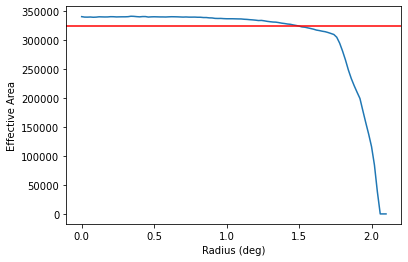

In [4]:
# vignetting

vfile = f"{os.environ['HOME']}/other_repos/f_factors/data/vignettingF.txt"
M1D = 8.36 #clear aperture as in Optical design
aa = np.loadtxt(vfile, skiprows=12)
vr = aa[:,0]
vv = aa[:,1]

def calc_eff_area(radius):
    area = np.interp(radius, vr, vv) * np.pi * (M1D / 2) ** 2 * 100**2
    return area

key_num_effarea = np.pi*(6.423/2*100)**2

plt.plot(vr, calc_eff_area(vr))
plt.axhline(key_num_effarea, color='r')
plt.xlabel('Radius (deg)')
plt.ylabel('Effective Area')

In [5]:
radii = []
effarea = []
for det in cam:
    detname = det.getName()
    raft, chip = detname.split('_')
    if raft in ['R00', 'R04', 'R40', 'R44']:
        continue
    for amp in det:
        k = amp.getName()
        radii.append(radius[detname][k])
        effarea.append(calc_eff_area(radius[detname][k]))

Text(0, 0.5, 'Effective Area')

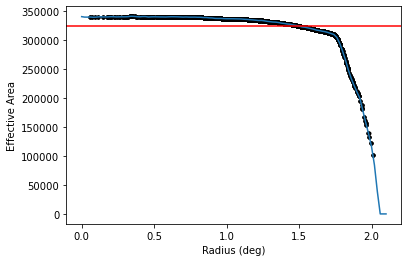

In [6]:
plt.plot(radii, effarea, 'k.')
plt.plot(vr, calc_eff_area(vr))
plt.axhline(key_num_effarea, color='r')
plt.xlabel('Radius (deg)')
plt.ylabel('Effective Area')

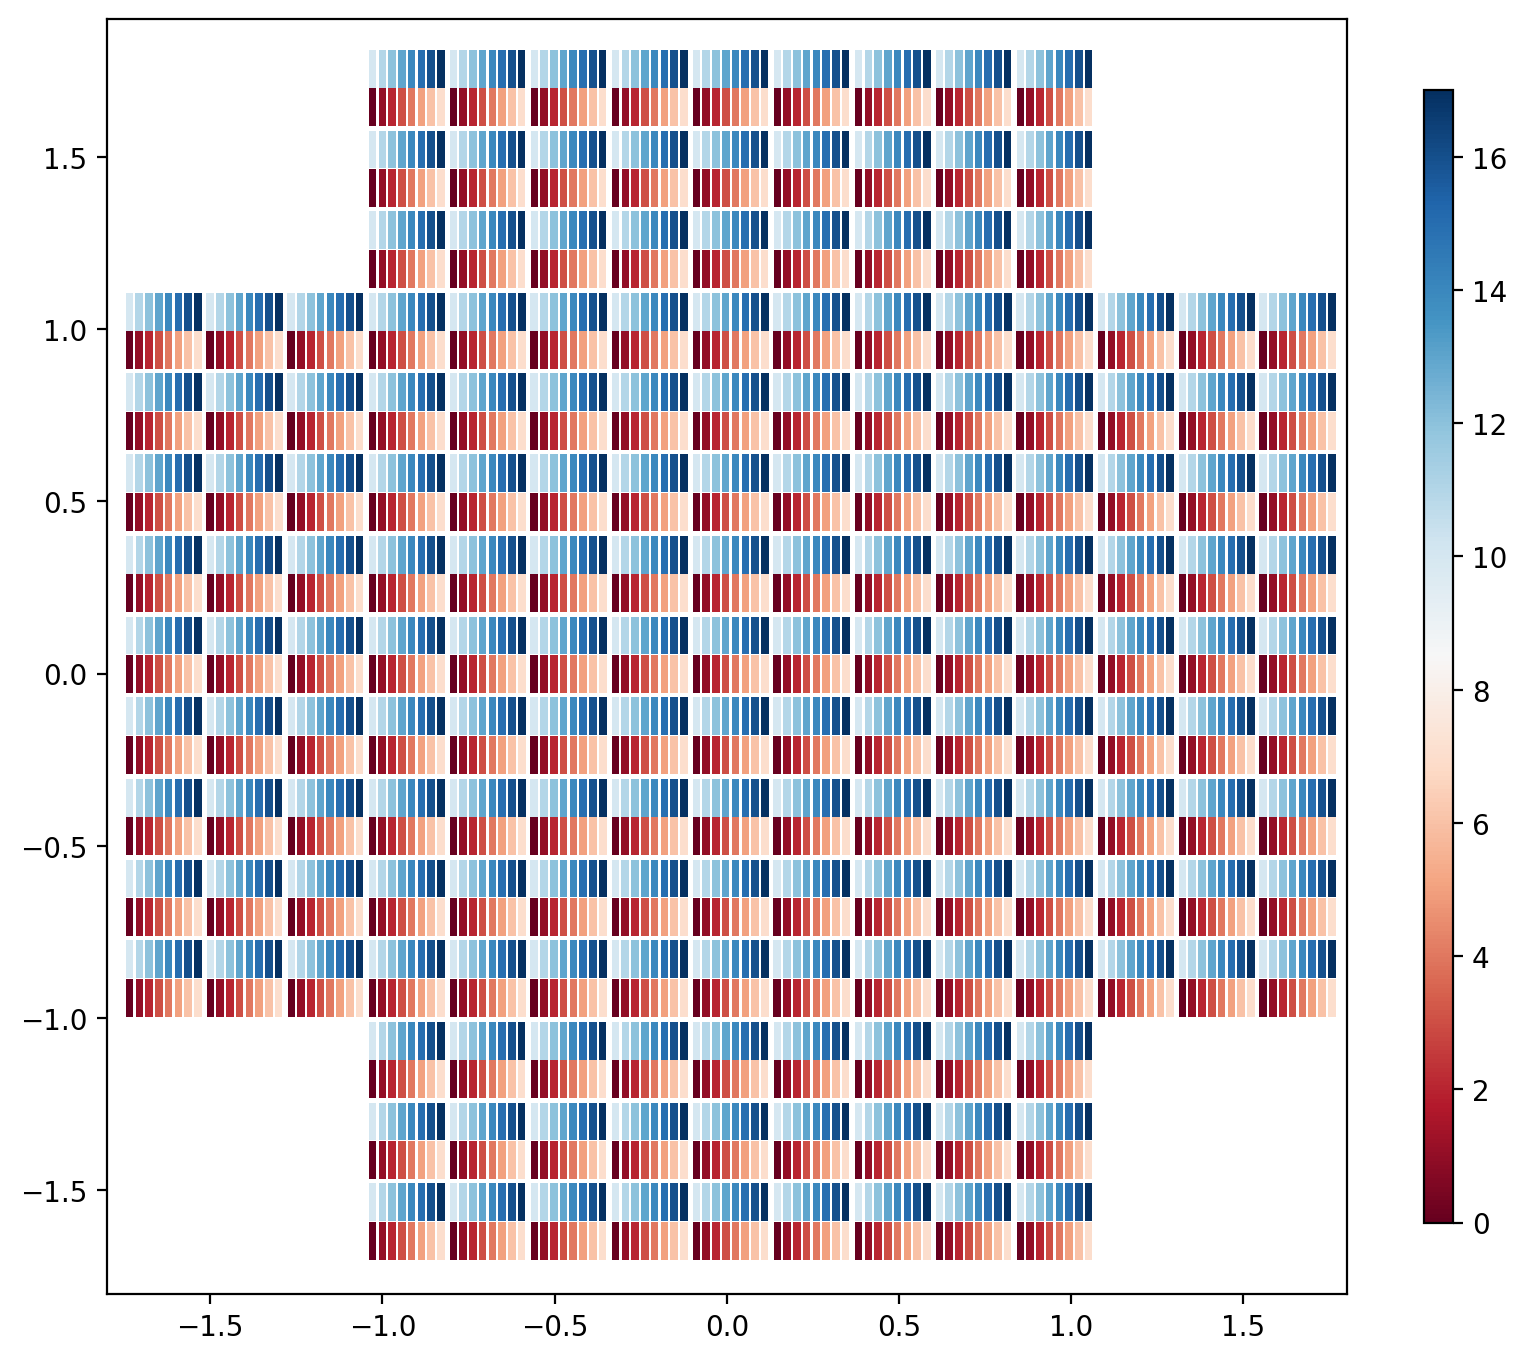

In [7]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.set_aspect('equal')
patches = []
i = []
for det in raDeg:
    for amp in raDeg[det]:
        i.append(float(amp.replace('C', '')))
        patches.append(Rectangle([raDeg[det][amp], decDeg[det][amp]], 0.022, 0.11))
pc=PatchCollection(patches, edgecolor=None, cmap='RdBu')
pc.set_array(np.array(i))
ax.add_collection(pc)
fig.colorbar(pc, shrink=0.75, aspect=40)
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.8, 1.9)
plt.savefig('focal_plane.png')

In [8]:
detectors = {}
vendors = {}

defaultDirs = st.setDefaultDirs()

vendorQE = {}
vendorQE['e2v'] = st.buildDetector(defaultDirs['detector'] + '/../e2v', addLosses=False)
vendorQE['itl'] = st.buildDetector(defaultDirs['detector'] + '/../itl', addLosses=False)
    

for det in cam:
    key = det.getName()
    raft, chip = key.split('_')
    if raft in ['R00', 'R04', 'R40', 'R44']:
        continue

    vendor = det.getSerial()[:3].lower()
    # Get the design QE
    detector0 = copy.deepcopy(vendorQE[vendor]) # design QE from this vendor
    
    detectors[f'{raft}_{chip}'] = {}
    
    ## Get QE from butler/amp info (have to interpolate to build)
    # this is needed if there are only 6 QE measurements per amp
    idx = np.where(detector0.sb>0.01)
    idx1=idx[0][0]-1
    idx2=idx[0][-1]+1

    x1 = detector0.wavelen[idx1]
    y1 = detector0.sb[idx1]
    x2 = detector0.wavelen[idx2]
    y2 = detector0.sb[idx2]

    print('Reading QE for %s_%s'%(raft,chip))
    qe_curve = butler.get('qe_curve', raftName=raft, detectorName=chip,
                          calibDate='1970-01-01T00:00:00')
    for amp in det:            
        wavelen = detector0.wavelen 

        k = amp.getName()
        if len(qe_curve.data[k][0])>10:
            wlen = qe_curve.data[k][0]
            eff = qe_curve.data[k][1]
            f = interp1d(wlen.value, eff.value, fill_value=0, bounds_error=False, kind='quadratic')
        else:
            aa = np.append(x1, qe_curve.data[k][0].value)
            aa = np.append(aa, x2)
            wlen = aa * qe_curve.data[k][0].unit

            aa = np.append(y1, qe_curve.data[k][1].value)
            aa = np.append(aa, y2)
            eff = aa * qe_curve.data[k][1].unit
            # quadratic causes overshoot here
            f = interp1d(wlen.value, eff.value, fill_value=0, bounds_error=False, kind='slinear')

        sb = f(wavelen)*0.01
        sb[np.isnan(sb)] = 0
        if np.max(sb)>1.5:
            print('These seem too LARGE ', k)
            print(np.max(sb))
            sb = 0
        if np.max(sb)<0.2: #3 dead channels, 1 out of each of R01, R10, and R30; see camera confluence page table
            print('dead channel: %s %s, max sb = %.2f'%(key, amp.getName(), np.max(sb)))
            # Skip the known bad amps
            continue
            
        detectors[f'{raft}_{chip}'][k] = Bandpass()
        detectors[f'{raft}_{chip}'][k].setBandpass(wavelen, sb)
        vendors[f'{raft}_{chip}'] = vendor

Reading QE for R01_S00
Reading QE for R01_S01
dead channel: R01_S01 C00, max sb = 0.11
Reading QE for R01_S02
Reading QE for R01_S10
Reading QE for R01_S11
Reading QE for R01_S12
Reading QE for R01_S20
Reading QE for R01_S21
Reading QE for R01_S22
Reading QE for R02_S00
Reading QE for R02_S01
Reading QE for R02_S02
Reading QE for R02_S10
Reading QE for R02_S11
Reading QE for R02_S12
Reading QE for R02_S20
Reading QE for R02_S21
Reading QE for R02_S22
Reading QE for R03_S00
Reading QE for R03_S01
Reading QE for R03_S02
Reading QE for R03_S10
Reading QE for R03_S11
Reading QE for R03_S12
Reading QE for R03_S20
Reading QE for R03_S21
Reading QE for R03_S22
Reading QE for R10_S00
dead channel: R10_S00 C00, max sb = 0.00
Reading QE for R10_S01
Reading QE for R10_S02
Reading QE for R10_S10
Reading QE for R10_S11
Reading QE for R10_S12
Reading QE for R10_S20
Reading QE for R10_S21
Reading QE for R10_S22
Reading QE for R11_S00
Reading QE for R11_S01
Reading QE for R11_S02
Reading QE for R11_S1

/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_26243/2843331022.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


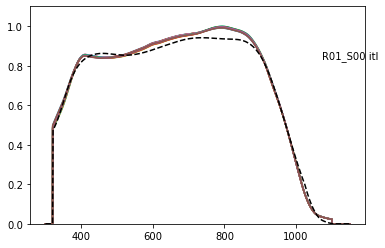

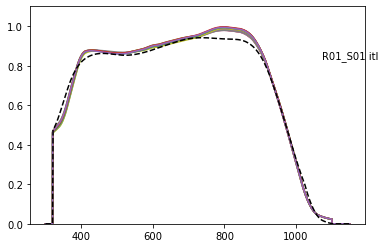

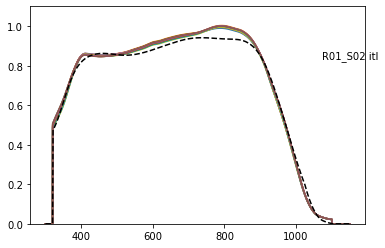

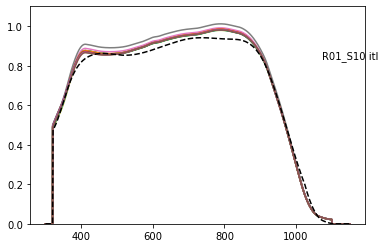

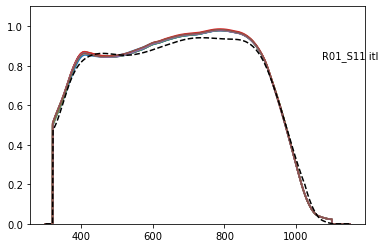

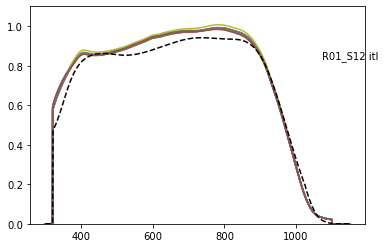

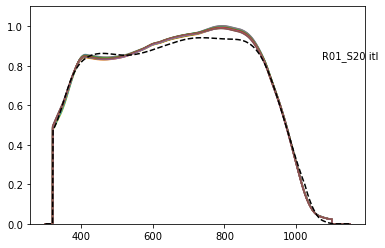

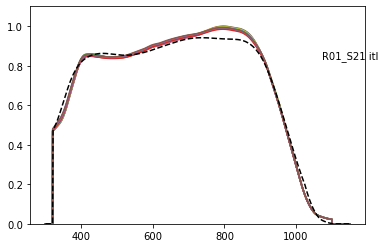

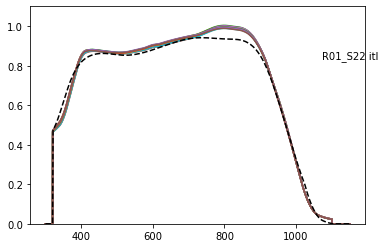

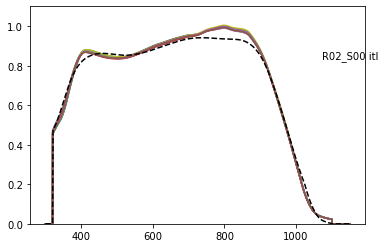

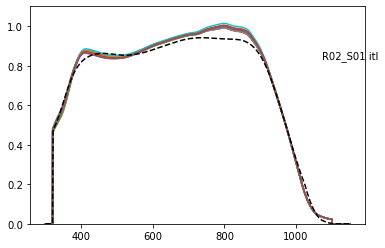

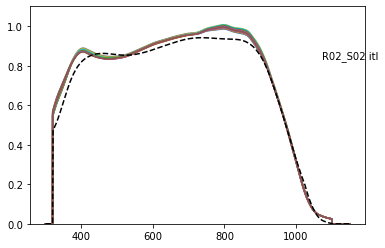

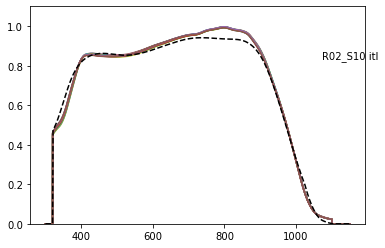

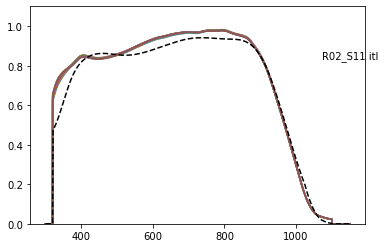

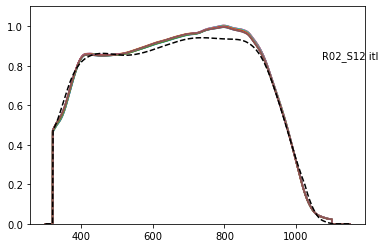

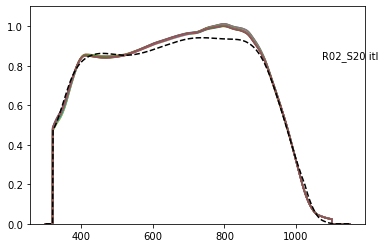

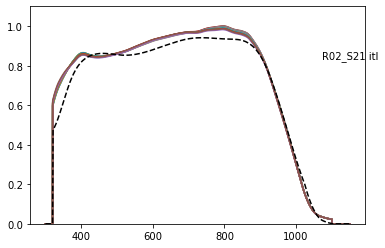

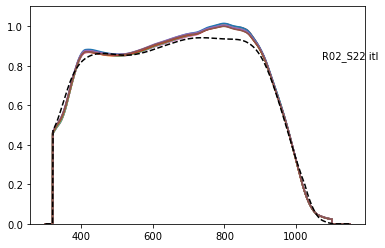

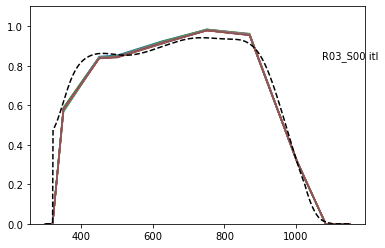

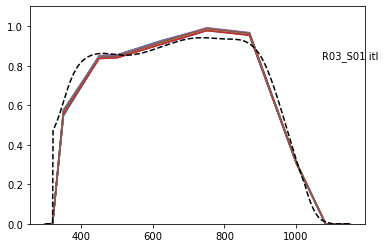

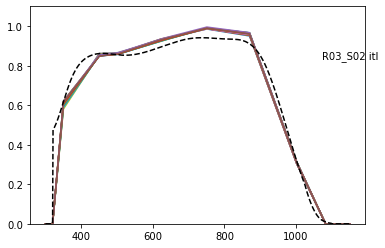

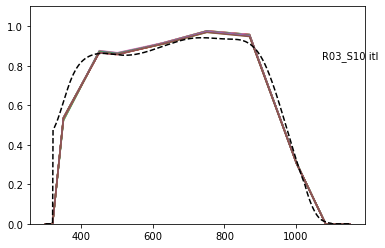

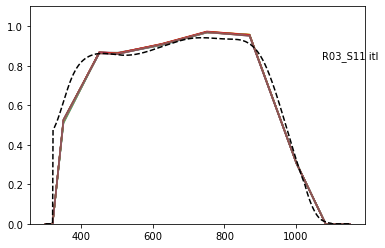

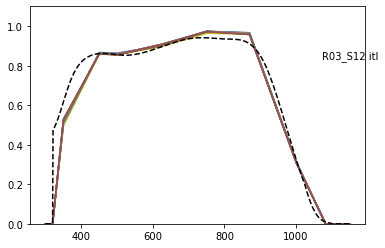

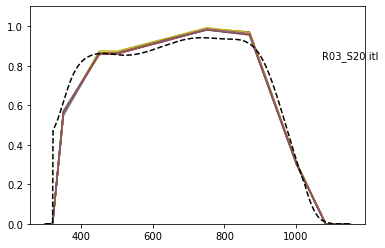

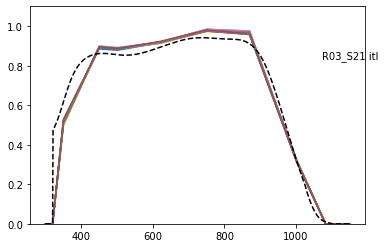

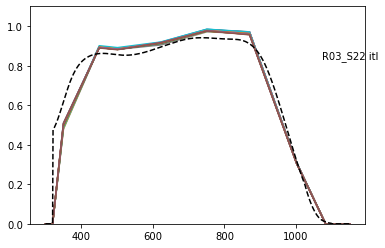

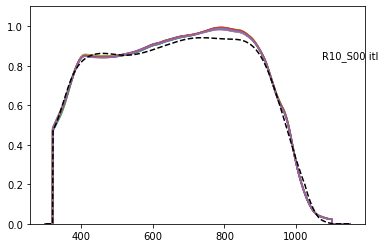

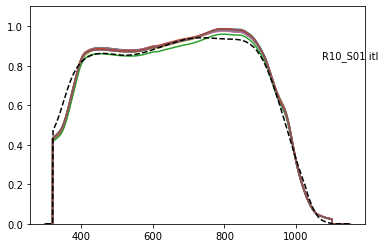

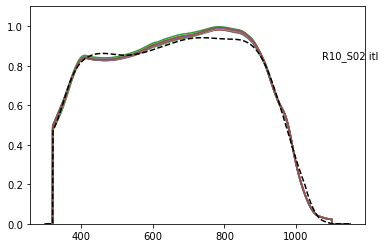

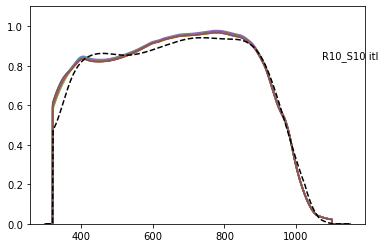

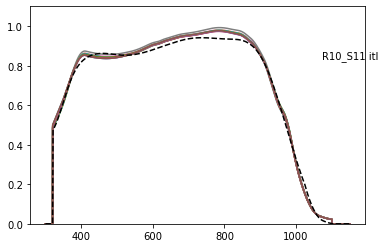

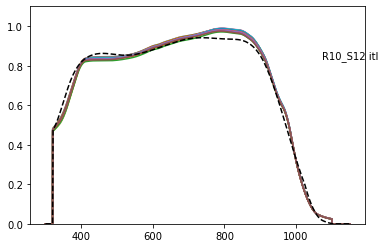

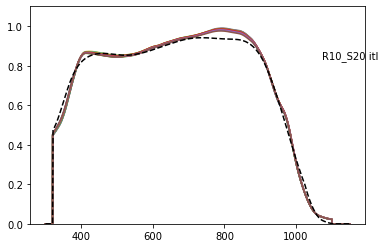

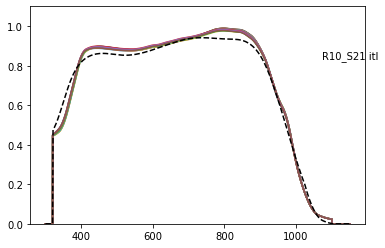

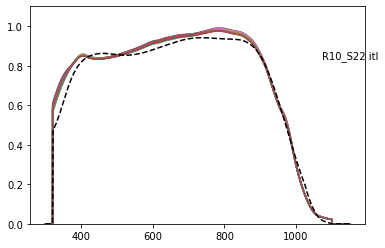

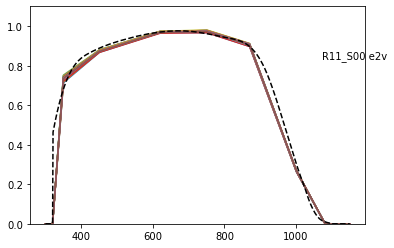

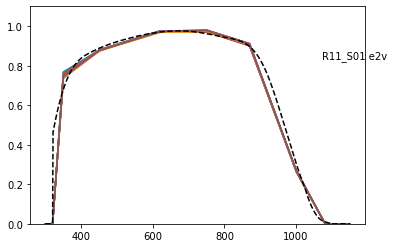

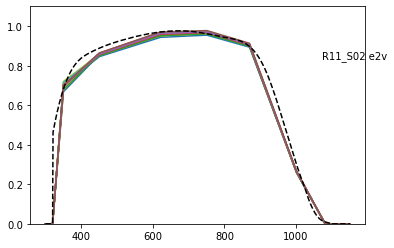

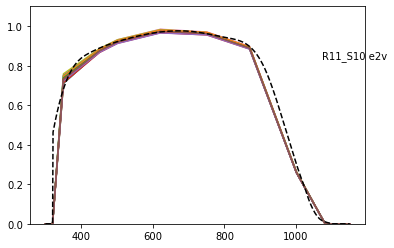

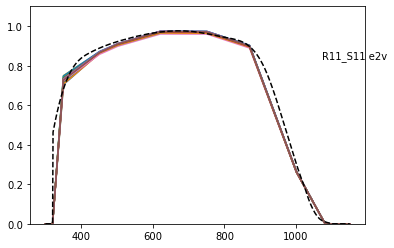

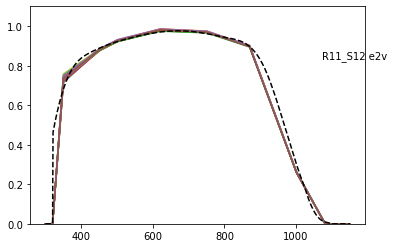

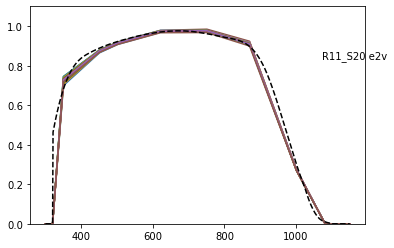

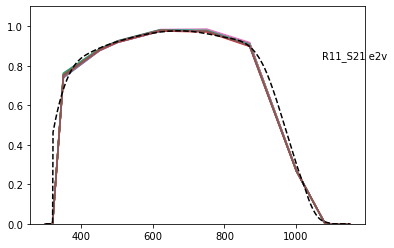

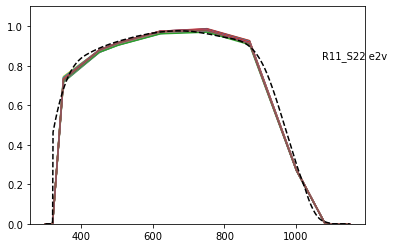

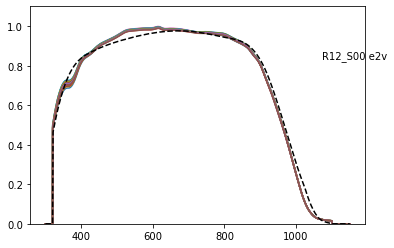

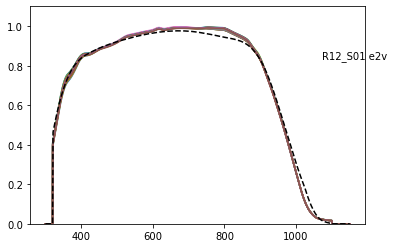

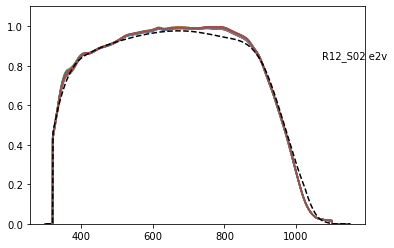

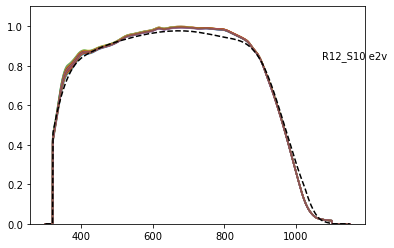

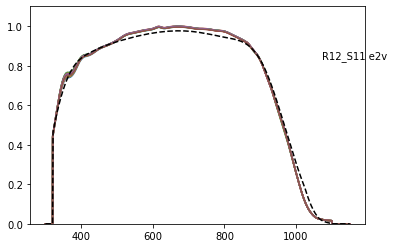

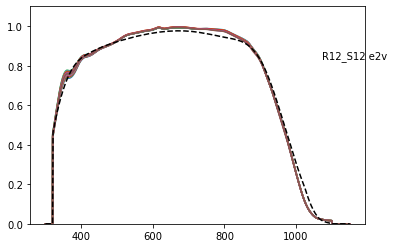

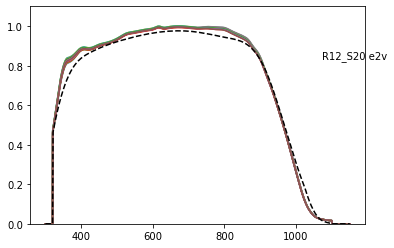

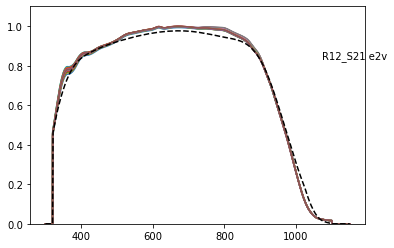

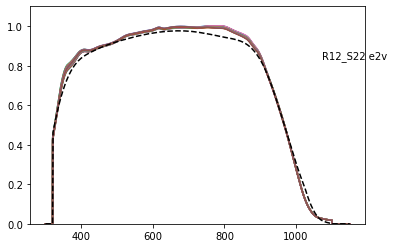

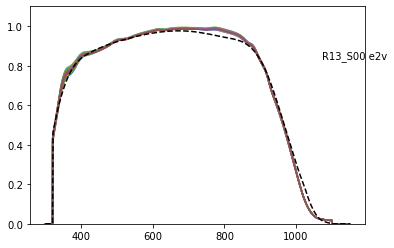

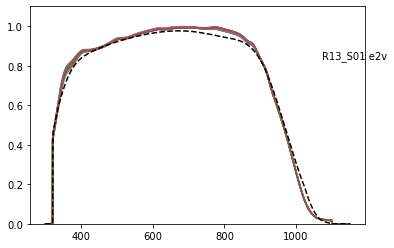

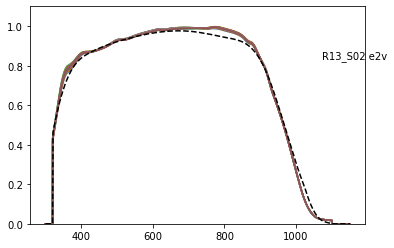

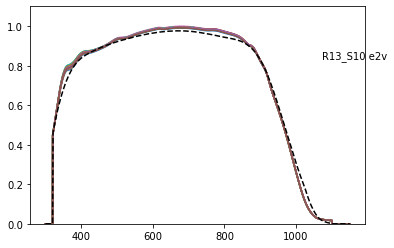

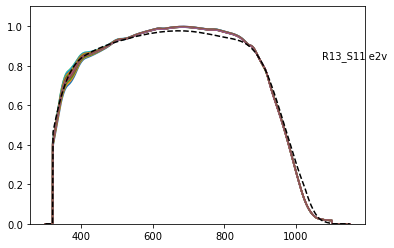

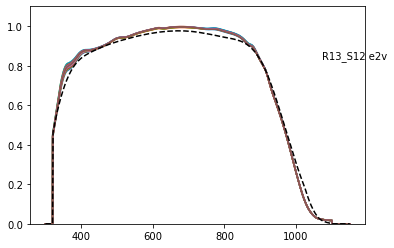

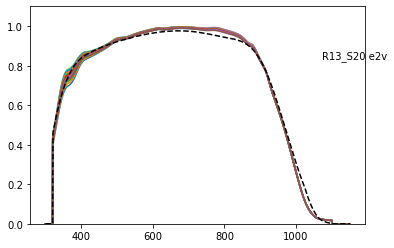

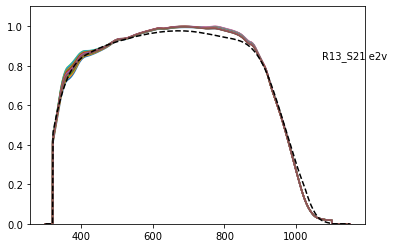

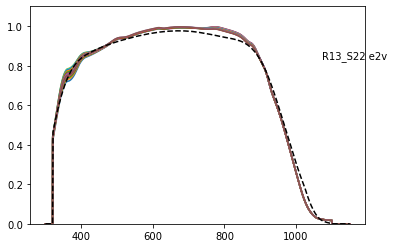

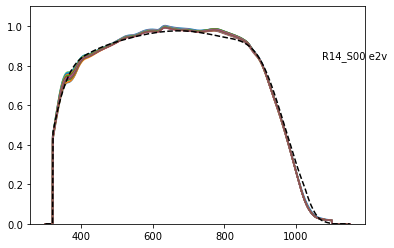

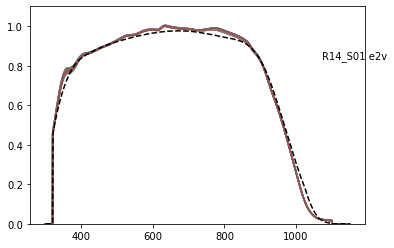

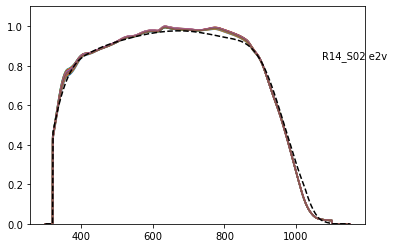

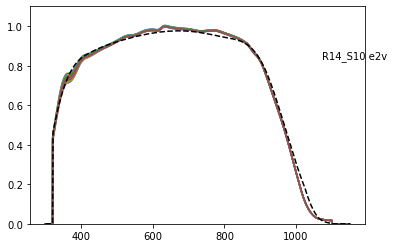

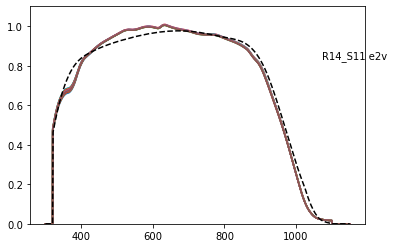

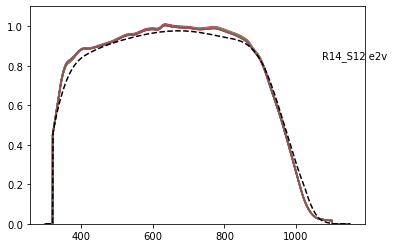

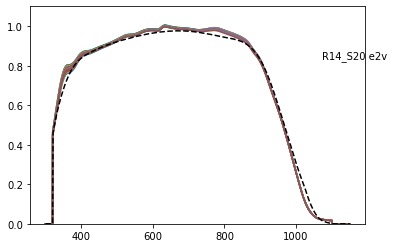

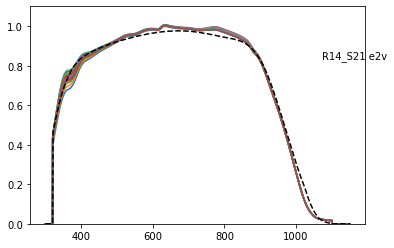

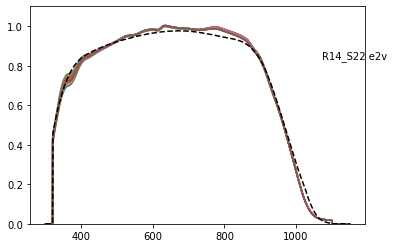

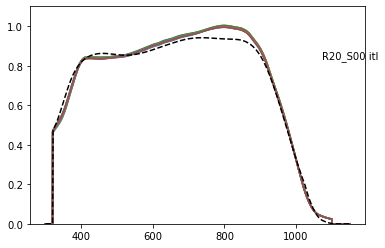

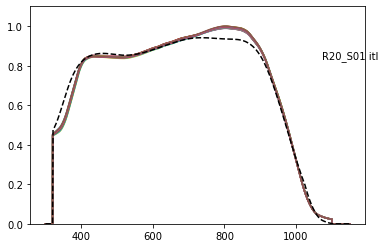

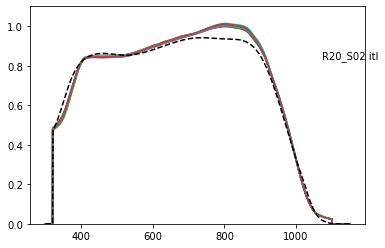

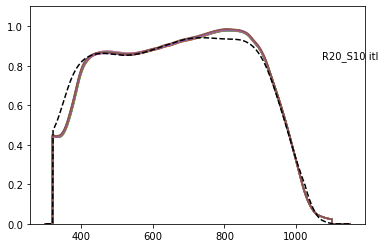

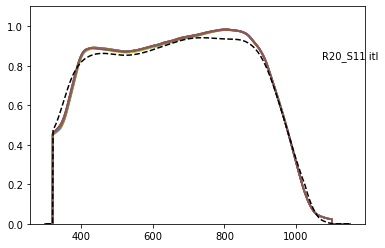

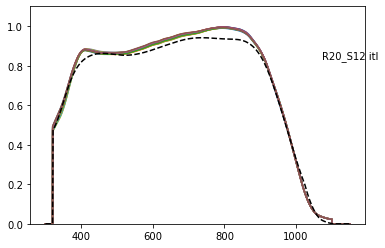

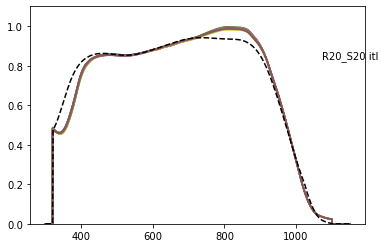

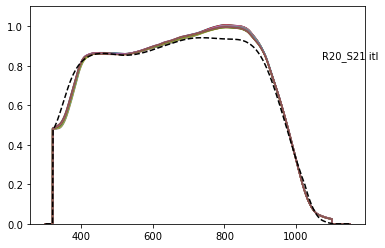

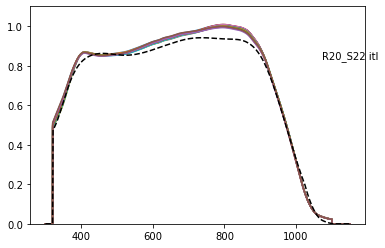

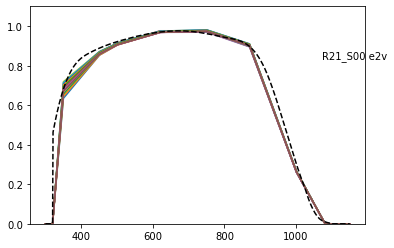

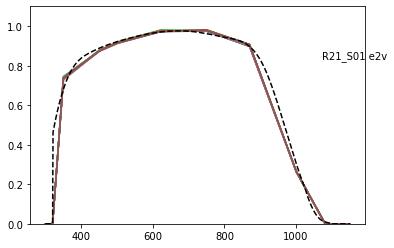

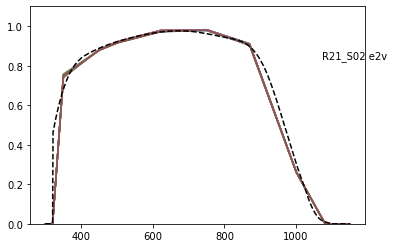

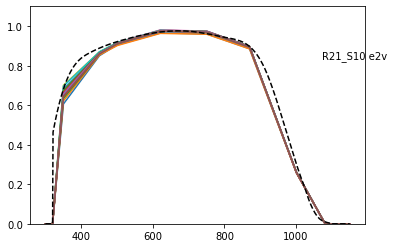

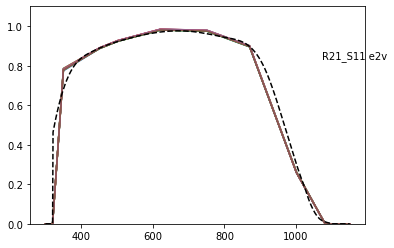

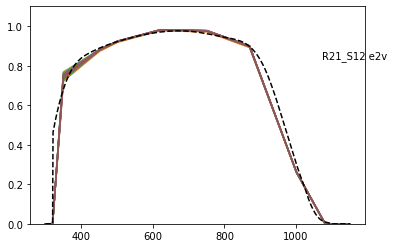

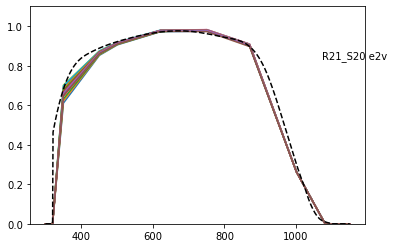

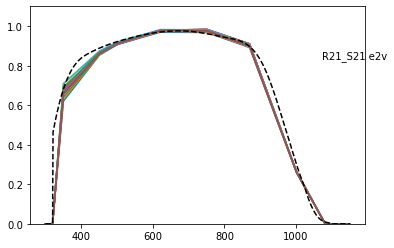

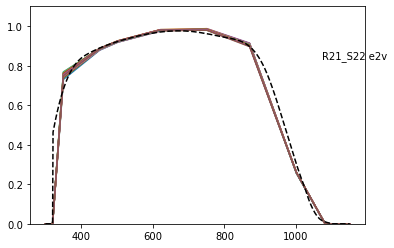

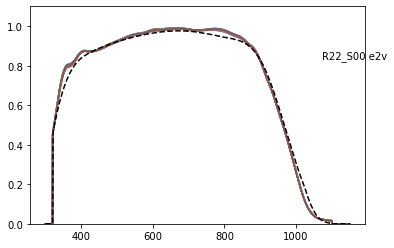

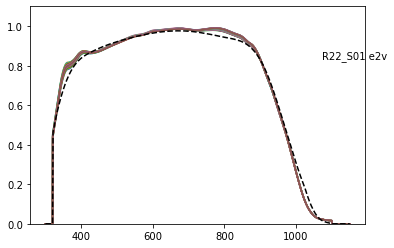

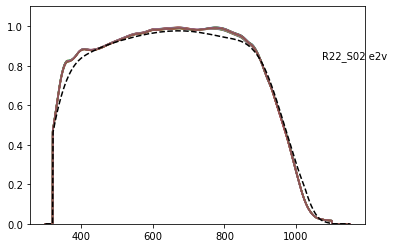

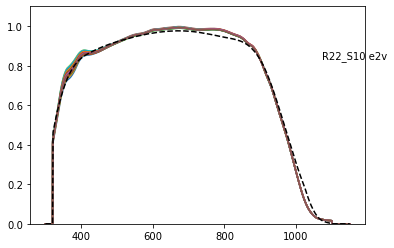

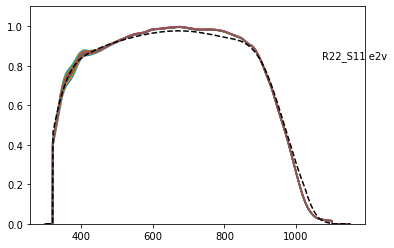

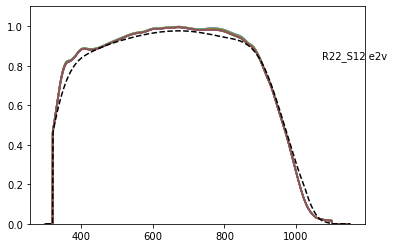

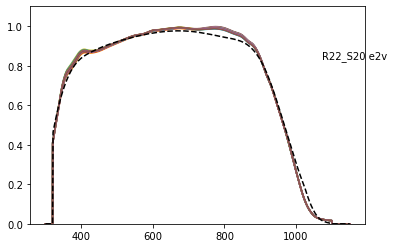

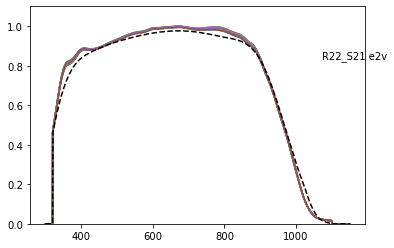

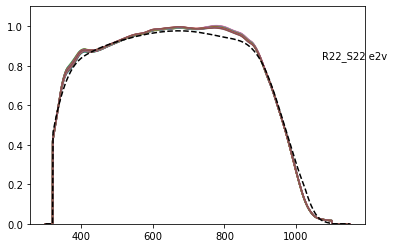

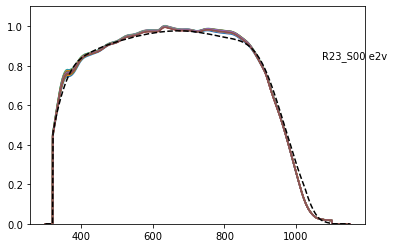

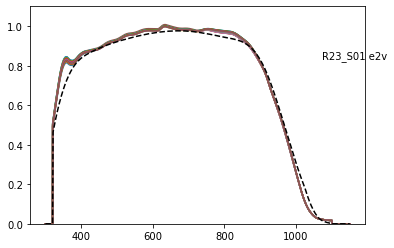

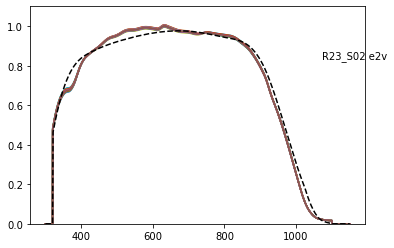

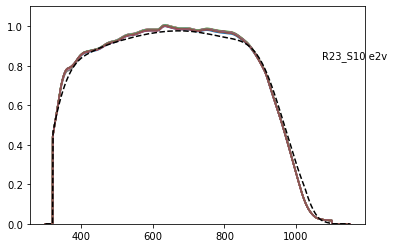

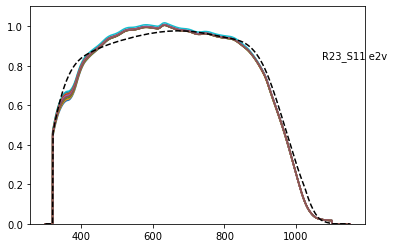

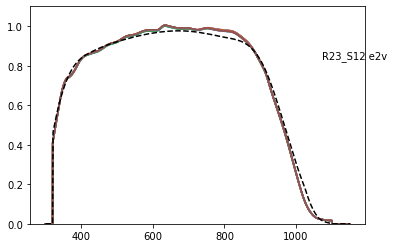

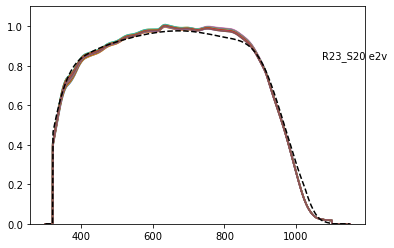

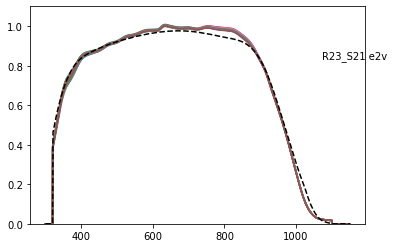

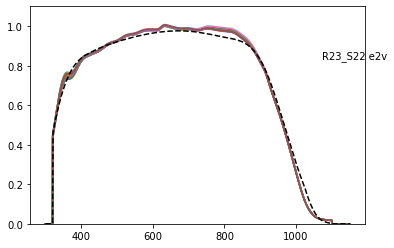

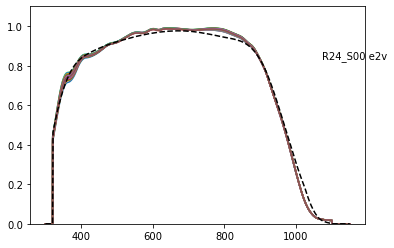

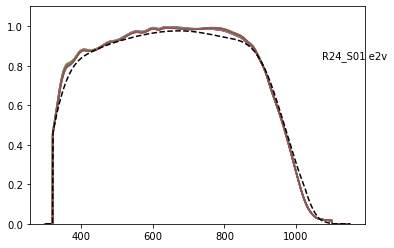

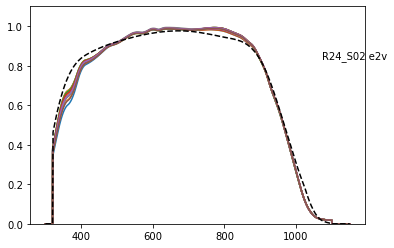

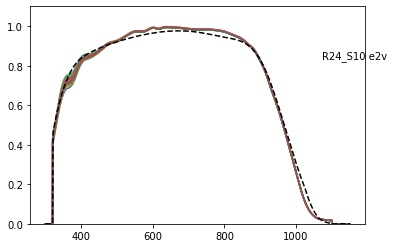

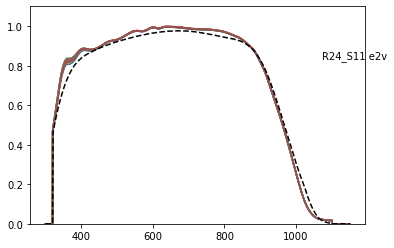

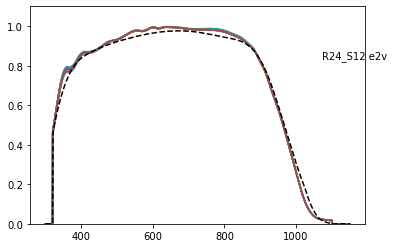

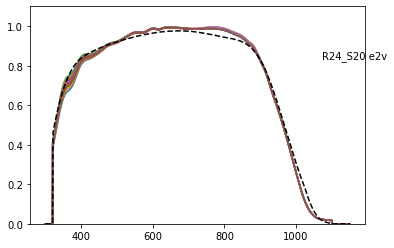

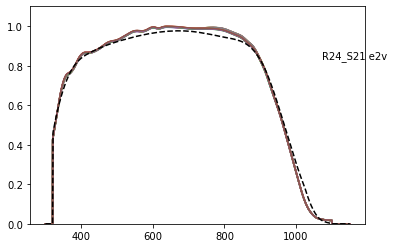

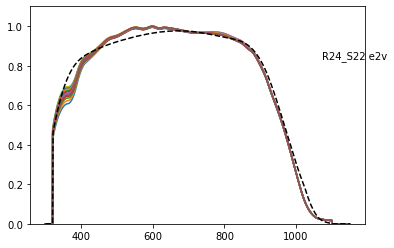

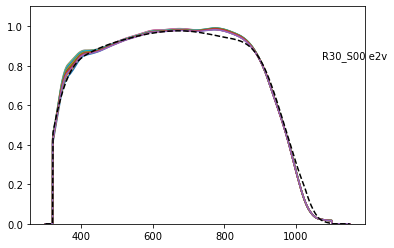

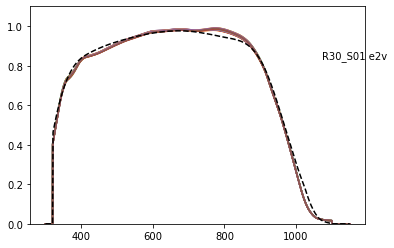

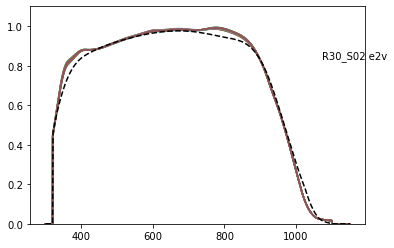

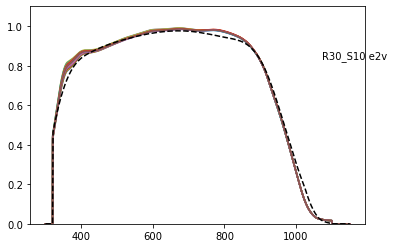

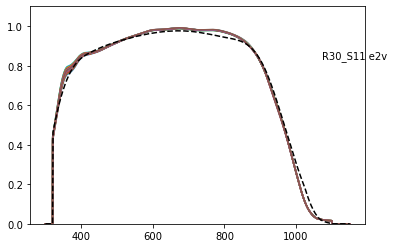

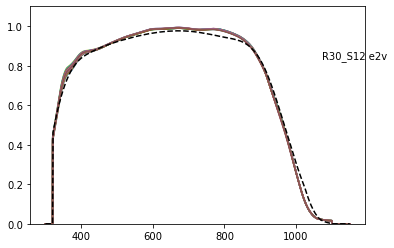

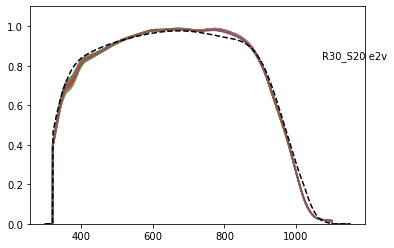

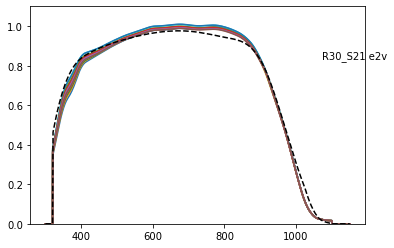

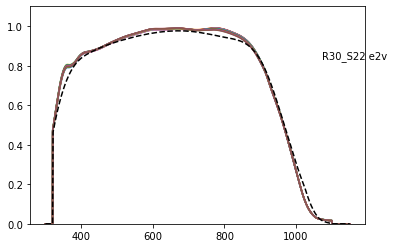

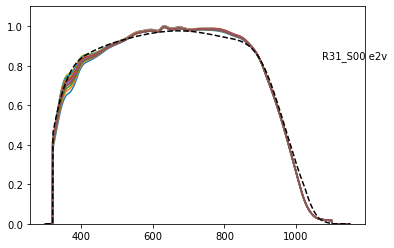

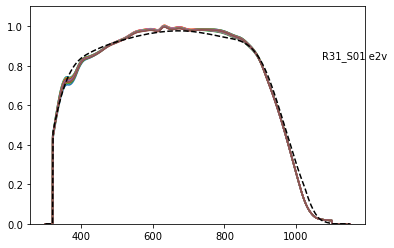

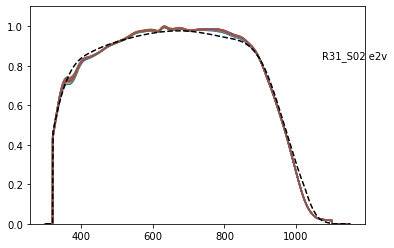

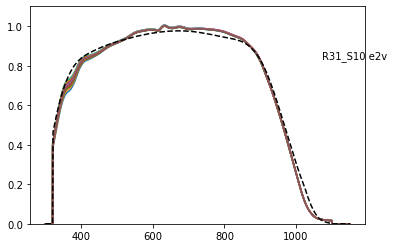

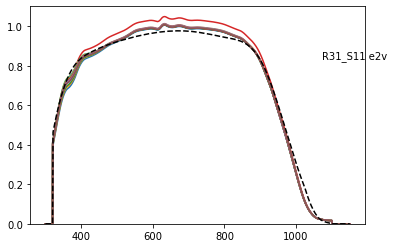

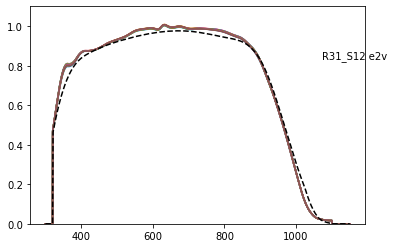

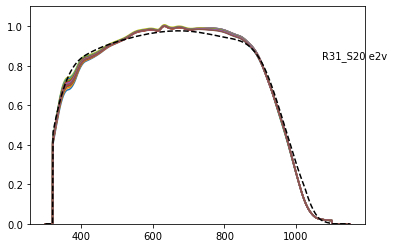

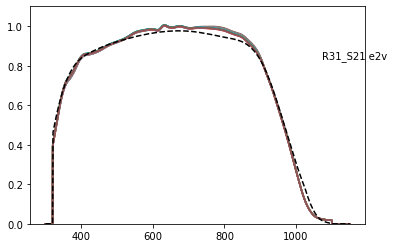

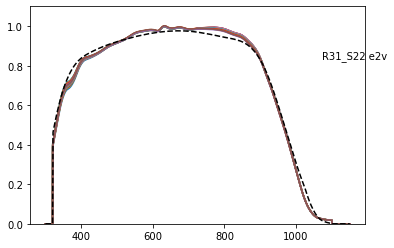

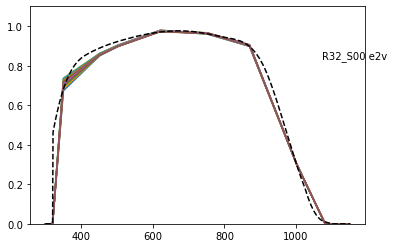

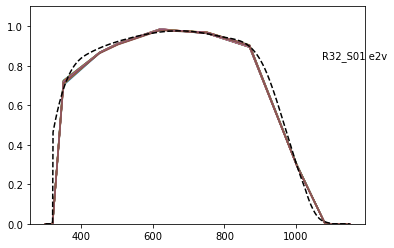

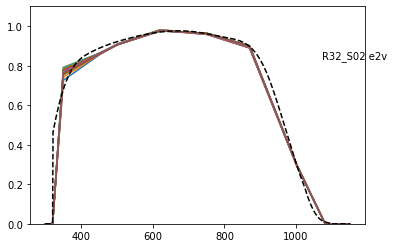

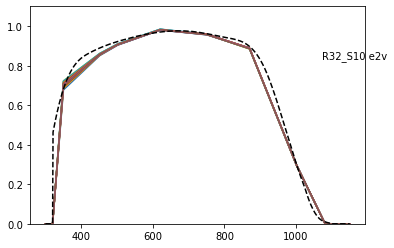

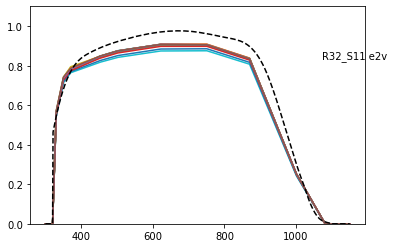

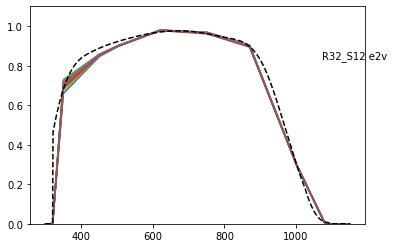

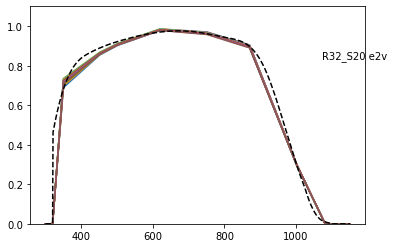

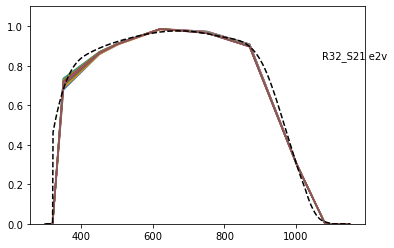

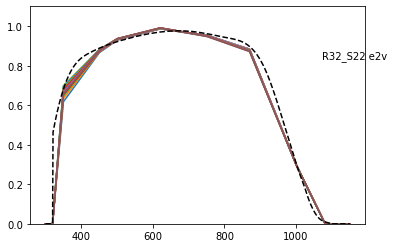

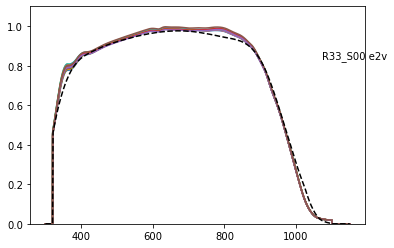

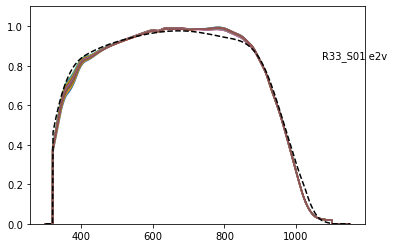

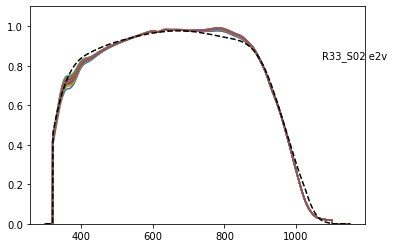

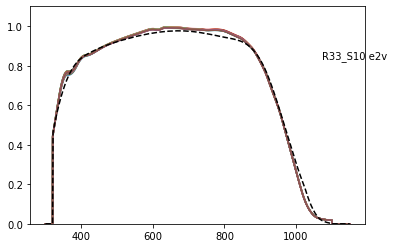

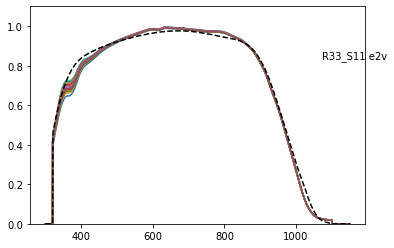

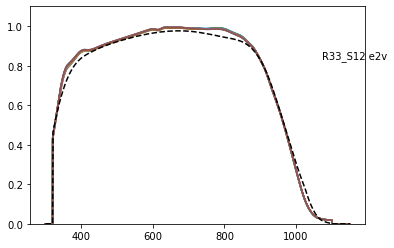

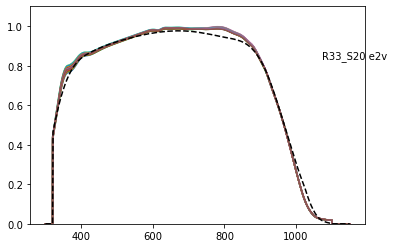

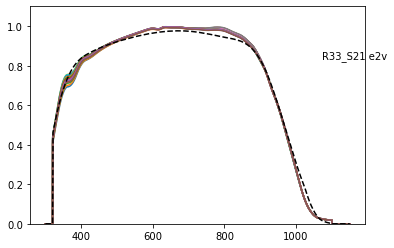

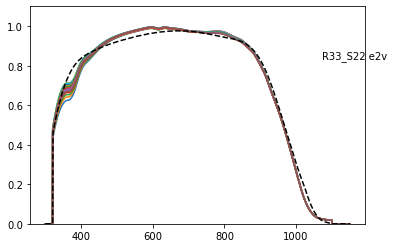

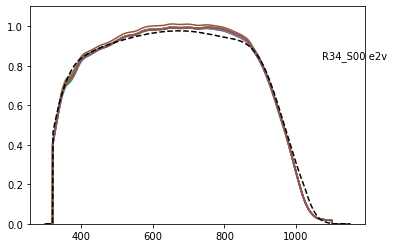

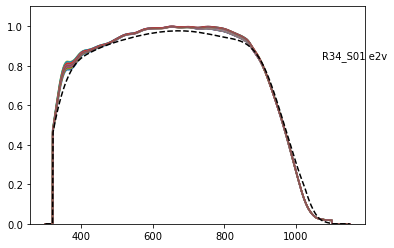

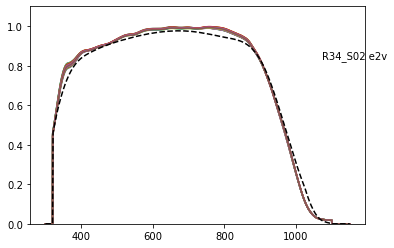

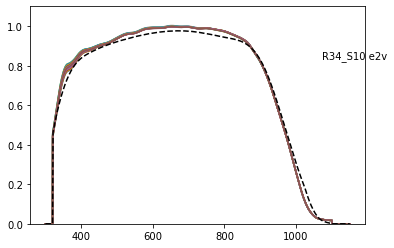

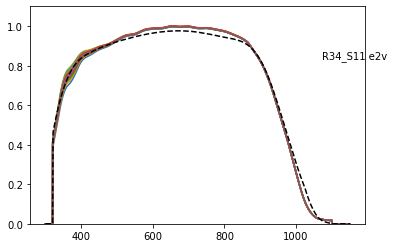

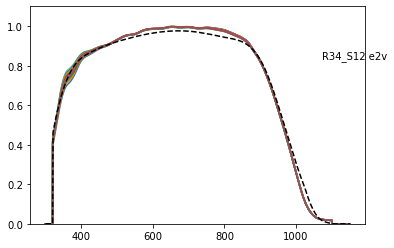

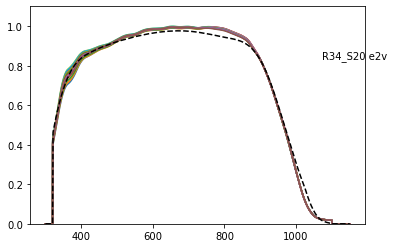

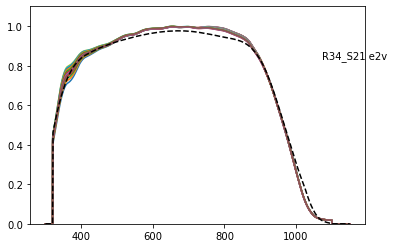

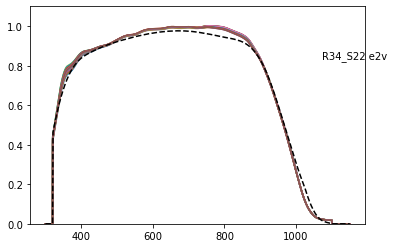

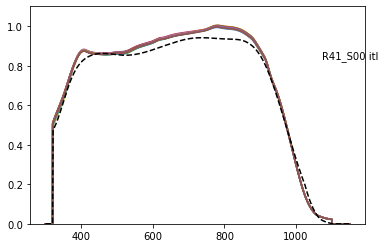

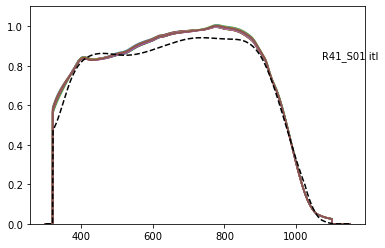

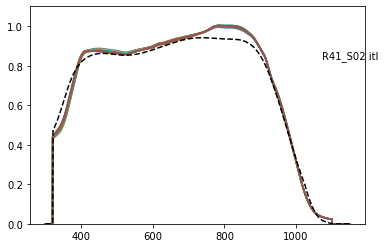

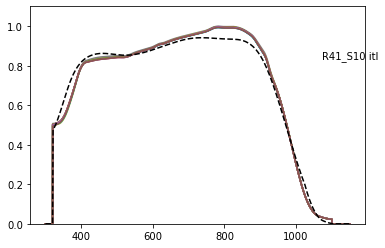

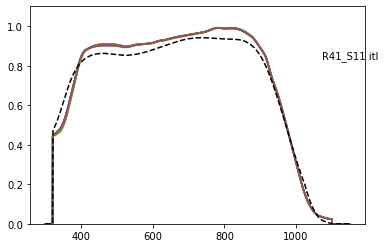

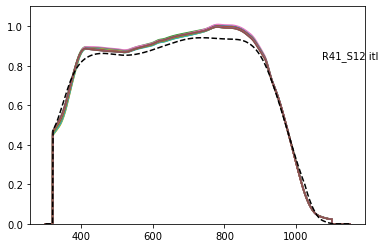

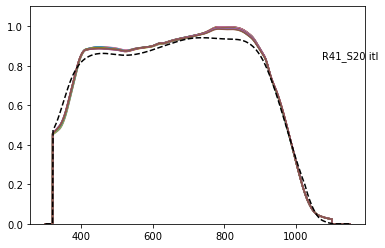

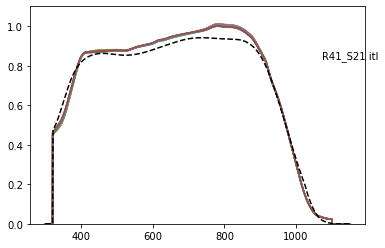

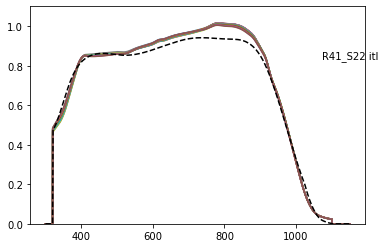

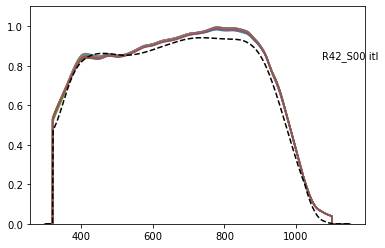

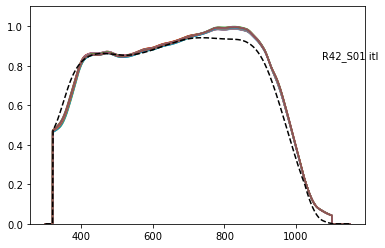

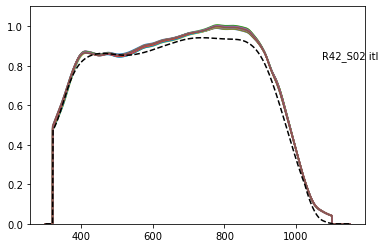

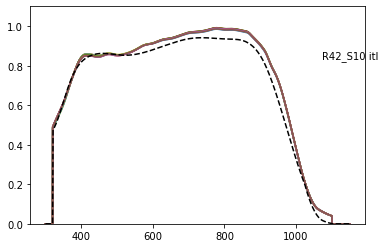

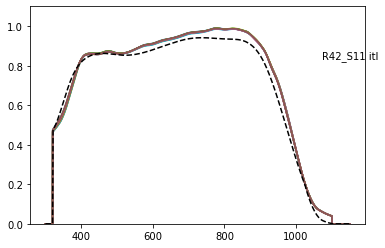

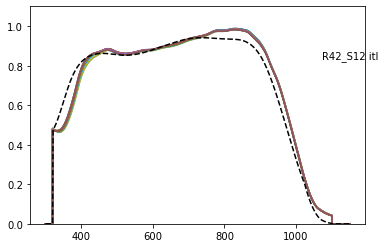

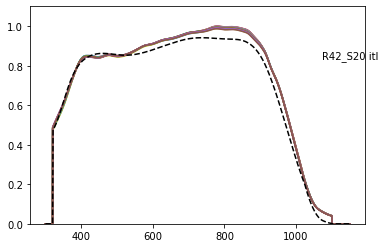

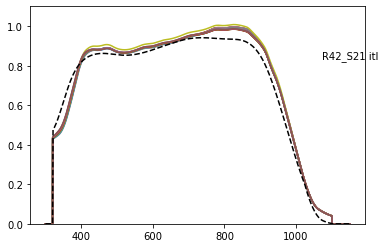

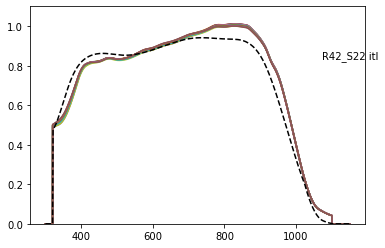

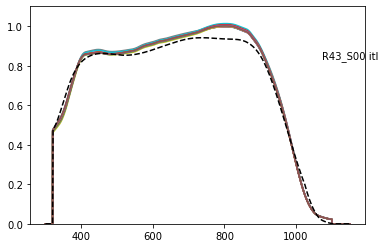

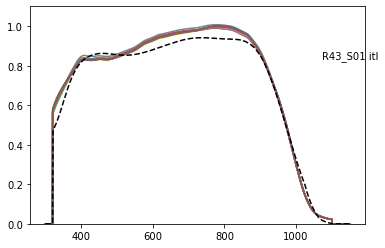

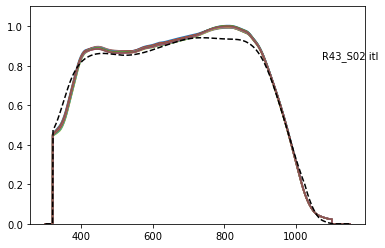

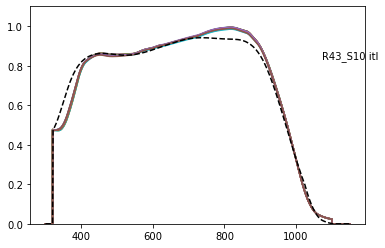

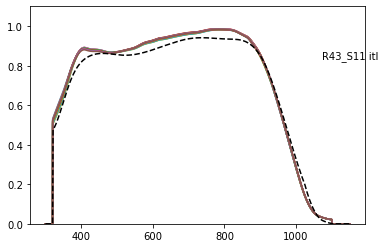

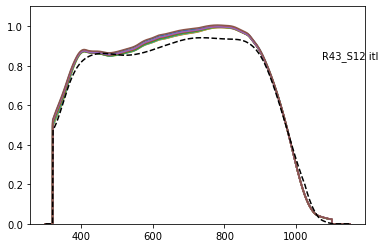

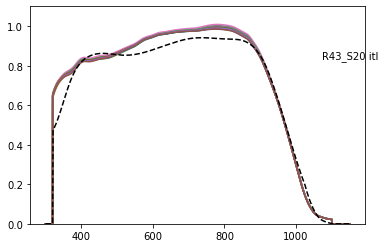

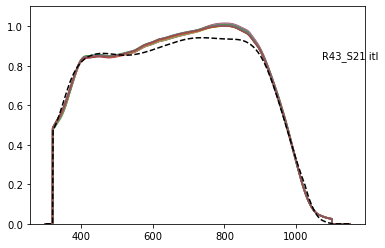

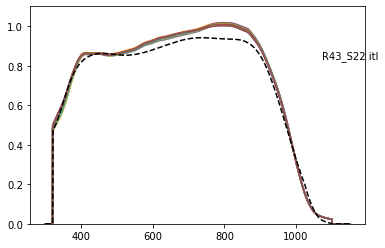

In [9]:
for raftchip in detectors:
    vendor = vendors[raftchip] 
    plt.figure()
    for amp in detectors[raftchip]:
        plt.plot(detectors[raftchip][amp].wavelen, detectors[raftchip][amp].sb)
    plt.plot(vendorQE[vendor].wavelen, vendorQE[vendor].sb, 'k--')
    plt.figtext(0.8, 0.7, f'{raftchip} {vendor}')
    plt.ylim(0, 1.1)

In [10]:
#series = '13040'
series = '13283'
filename = f'readnoise_{series}.pkl'
readnoises = pd.read_pickle(filename)

In [54]:
readnoises['R12_S02']

[5.57031774520874,
 5.65474271774292,
 5.626262187957764,
 5.502777576446533,
 5.685105800628662,
 5.595748424530029,
 5.589964866638184,
 5.630801677703857,
 5.645330905914307,
 6.3785786628723145,
 6.112989902496338,
 6.011203765869141,
 5.819519519805908,
 5.640388011932373,
 5.837666988372803,
 5.507133483886719]

In [12]:
n_readnoises = 0
n_detectors = 0
for raftchip in detectors:
    if len(readnoises[raftchip]) != len(list(detectors[raftchip].values())):
        print(raftchip, len(readnoises[raftchip]), len(list(detectors[raftchip].values())))
    n_readnoises += len(readnoises[raftchip])
    n_detectors += len(detectors[raftchip].values())
print(n_readnoises, n_detectors)

R01_S01 16 15
R10_S00 16 15
R30_S00 16 15
3024 3021


(0.0, 1.1)

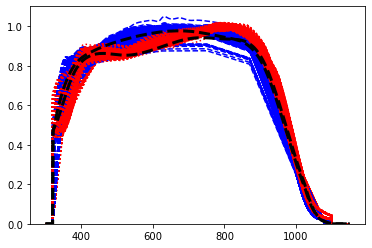

In [13]:
for raftchip in detectors:
    for amp in detectors[raftchip]:
        if vendors[raftchip] == 'itl':
            linestyle=':'
            color = 'r'
        else:
            linestyle = '--'
            color='b'
        plt.plot(detectors[raftchip][amp].wavelen, detectors[raftchip][amp].sb, 
                 linestyle=linestyle, color=color)
for vendor in vendorQE:
    plt.plot(vendorQE[vendor].wavelen, vendorQE[vendor].sb, 'k--', label=vendor, linewidth=3)
plt.ylim(0, 1.1)

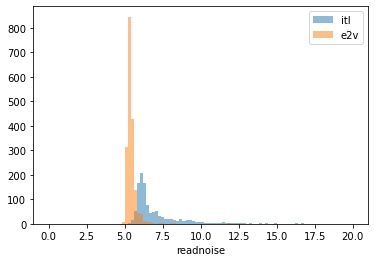

In [14]:
itl_readnoise = []
e2v_readnoise = []
for raftchip in detectors:
    if vendors[raftchip] == 'itl':
        itl_readnoise.append(readnoises[raftchip])
    else:
        e2v_readnoise.append(readnoises[raftchip])
        
itl_readnoise = np.array(itl_readnoise).flatten()
e2v_readnoise = np.array(e2v_readnoise).flatten()
plt.hist(itl_readnoise, bins=100, label='itl', range=(0, 20), alpha=0.5)
plt.hist(e2v_readnoise, bins=100, label='e2v', range=(0, 20), alpha=0.5)
plt.xlabel('readnoise')
plt.legend(loc='upper right')

In [15]:
joint_min = np.ones(len(vendorQE['e2v'].wavelen))
joint_max = np.zeros(len(vendorQE['e2v'].wavelen))

for raftchip in detectors:
    for amp in detectors[raftchip]:
        joint_min = np.min([joint_min, detectors[raftchip][amp].sb], axis=0)
        joint_max = np.max([joint_max, detectors[raftchip][amp].sb], axis=0)

(0.0, 1.1)

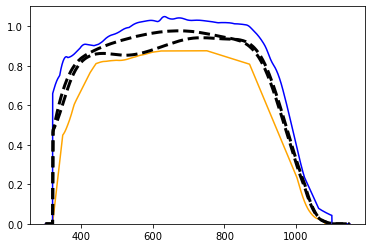

In [16]:
plt.plot(vendorQE['e2v'].wavelen, joint_min, color='orange')
plt.plot(vendorQE['e2v'].wavelen, joint_max, color='blue')
for vendor in vendorQE:
    plt.plot(vendorQE[vendor].wavelen, vendorQE[vendor].sb, 'k--', label=vendor, linewidth=3)
plt.ylim(0, 1.1)

In [17]:
# corresponds to fwhm500 = 0.475 with standard seeing model
skymag_srd = {'u': 22.92,
             'g': 22.27,
             'r': 21.20,
             'i': 20.47,
             'z': 19.59,
             'y': 18.63}
# ok .. even LSE-40 from above had sky in r band slightly darker, so adjust again.
for f in skymag_srd:
    skymag_srd[f] = skymag_srd[f] - 0.2
    
seeing_srd = {'u': 0.77,
             'g': 0.73,
             'r': 0.70,
             'i': 0.67,
             'z': 0.65,
             'y': 0.63}
    
fwhm500_srd = 0.475

losses_srd = False

# Sim reference values
skymag_sim = {'u': 22.68,
           'g': 22.11,
           'r': 21.11,
           'i': 20.39,
           'z': 19.43,
           'y': 18.63}
seeing_sim = dict(zip(('u', 'g', 'r', 'i', 'z', 'y'), list(SeeingModel()(0.72, 1)['fwhmEff'])))

losses_sim = True

In [18]:
ref = 'sim'

if ref == 'sim':
    seeing = seeing_sim
    darkmags = skymag_sim
    addLosses = losses_sim
    expTime = {}
    expTime['u'] = 30
    for f in 'grizy':
        expTime[f] = 15
    nexp = {}
    nexp['u'] = 1
    for f in 'grizy':
        nexp[f] = 2
    expTime
if ref == 'srd':
    seeing = seeing_srd
    darkmags = skymag_srd
    addLosses = losses_srd
    expTime = {}
    nexp = {}
    for f in 'ugrizy':
        expTime[f] = 15
        nexp[f] = 2

        
darksky = Sed()
darksky.readSED_flambda(os.path.join(defaultDirs['atmosphere'], 'darksky.dat'))


atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
mirror1 = st.buildMirror(defaultDirs['mirror1'], addLosses)
mirror2 = st.buildMirror(defaultDirs['mirror2'], addLosses)
mirror3 = st.buildMirror(defaultDirs['mirror3'], addLosses)
lens1 = st.buildLens(defaultDirs['lens1'], addLosses)
lens2 = st.buildLens(defaultDirs['lens2'], addLosses)
lens3 = st.buildLens(defaultDirs['lens3'], addLosses)
filters = st.buildFilters(defaultDirs['filters'], addLosses)
detLosses = Bandpass()
# Losses for e2v and ITL are currently modeled as the same, just use joint
detLosses.readThroughput(os.path.join(defaultDirs['detector'], 'joint_losses/det_Losses.dat'))
# combine common elements:
hardware_nodet = {}
system_nodet = {}
wavelen = atmos.wavelen

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
for f in filterlist:
    sb = mirror1.sb * mirror2.sb * mirror3.sb
    sb *= lens1.sb * lens2.sb * lens3.sb * filters[f].sb
    if addLosses:
        sb *= detLosses.sb
    hardware_nodet[f] = Bandpass()
    hardware_nodet[f].setBandpass(wavelen, sb)
    system_nodet[f] = Bandpass()
    system_nodet[f].setBandpass(wavelen, sb * atmos.sb)

In [19]:
def genM5(filterName, hardware, system, skysed, skymags, fwhmEff, photParams):
    """Calculate m5 given the hardware, system and sky sed. 
    Also, skymags (dictionary or dataframe), fwhmEff (dictionary or dataframe), and single photParams.
    
    Call with photParams infinity (no noise) to calculate m5_infinity.
    """
    sky_copy = copy.deepcopy(skysed)
    fluxNorm = sky_copy.calcFluxNorm(skymags[filterName], hardware[filterName])
    sky_copy.multiplyFluxNorm(fluxNorm)
    m5 = calcM5(sky_copy, system[filterName], hardware[filterName], photParams, FWHMeff=fwhmEff[filterName])
    return m5

def calcCm(m5, skyMag, fwhmEff, kAtm, expTimeTotal=30, X=1.0, m5_infinity=None):
    Cm = (m5 
          - 0.5 * (skyMag - 21) 
          - 2.5 * np.log10(0.7/fwhmEff) 
          - 1.25 * np.log10(expTimeTotal/30.0) 
          + kAtm * (X-1))
    if m5_infinity is not None:
        Cm_infinity = (m5_infinity 
                       - 0.5 * (skyMag - 21)
                       - 2.5 * np.log10(0.7/fwhmEff)
                       - 1.25 * np.log10(expTimeTotal/30.0)
                       + kAtm * (X-1))
        dCm_infinity = Cm_infinity - Cm
    else:
        dCm_infinity = None
    return Cm, dCm_infinity

In [20]:
othernoise = 0
darkcurrent = 0.2
readnoise = 8.8

effarea = np.pi*(6.423/2*100)**2


detector = Bandpass()
detector.setBandpass(wavelen, joint_min)

hardware = {}
system = {}
for f in filterlist:
    sb = detector.sb * hardware_nodet[f].sb
    hardware[f] = Bandpass()
    hardware[f].setBandpass(wavelen, sb)
    sb = detector.sb * system_nodet[f].sb
    system[f] = Bandpass()
    system[f].setBandpass(wavelen, sb)

m5_min = {}
for f in filterlist:
    photParams = PhotometricParameters(exptime=expTime[f], nexp=nexp[f], gain=1,
                                       effarea=key_num_effarea,
                                       readnoise=readnoise, 
                                       othernoise=othernoise, darkcurrent=darkcurrent)
    m5_min[f] = genM5(f, hardware, system, darksky, darkmags, seeing, photParams)

detector = Bandpass()
detector.setBandpass(wavelen, joint_max)

hardware = {}
system = {}
for f in filterlist:
    sb = detector.sb * hardware_nodet[f].sb
    hardware[f] = Bandpass()
    hardware[f].setBandpass(wavelen, sb)
    sb = detector.sb * system_nodet[f].sb
    system[f] = Bandpass()
    system[f].setBandpass(wavelen, sb)

m5_max = {}
for f in filterlist:
    photParams = PhotometricParameters(exptime=expTime[f], nexp=nexp[f], gain=1,
                                       readnoise=readnoise, 
                                       effarea=key_num_effarea,
                                       othernoise=othernoise, darkcurrent=darkcurrent)
    m5_max[f] = genM5(f, hardware, system, darksky, darkmags, seeing, photParams)

In [21]:
hardware, system = st.buildHardwareAndSystem(defaultDirs, addLosses=addLosses, atmosphereOverride=atmos)
m5_ref = {}
m5_inf_ref = {}
Cm_ref = {}
dCm_inf_ref = {}

dwavelen = np.unique(np.diff(detector0.wavelen)).mean()

for f in filters:
    photParams = PhotometricParameters(exptime=expTime[f], nexp=nexp[f], gain=1,
                                       readnoise=readnoise, effarea=key_num_effarea,
                                       othernoise=othernoise, darkcurrent=darkcurrent)
    photParams_inf = PhotometricParameters(exptime=expTime[f], nexp=nexp[f], gain=1,
                                          readnoise=0, effarea=key_num_effarea,
                                          othernoise=0, darkcurrent=darkcurrent)
    m5_ref[f] = genM5(f, hardware, system, darksky, darkmags, seeing, photParams)
    m5_inf_ref[f] = genM5(f, hardware, system, darksky, darkmags, seeing, photParams_inf)
    Tb = np.sum(system[f].sb / system[f].wavelen) * dwavelen
    Sb = np.sum(hardware[f].sb / hardware[f].wavelen) * dwavelen
    kAtm = -2.5 * np.log10(Tb / Sb)
    Cm_ref[f], dCm_inf_ref[f] = calcCm(m5_ref[f], darkmags[f], seeing[f], 
                                       kAtm, expTimeTotal=30, X=1.0, 
                                       m5_infinity=m5_inf_ref[f])

In [22]:
pd.DataFrame([m5_min, m5_ref, m5_max], 
            index=['min all', 'ref system', 'max all']).round(2)[['u', 'g', 'r', 'i', 'z', 'y']]

u      g      r      i      z      y
min all     23.60  24.60  24.19  23.74  23.10  22.21
ref system  23.87  24.64  24.21  23.79  23.18  22.37
max all     24.02  24.71  24.30  23.84  23.25  22.54

(0.0, 1.1)

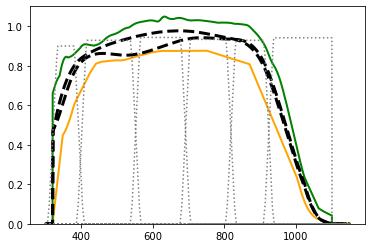

In [23]:
plt.plot(vendorQE['e2v'].wavelen, joint_min, color='orange', linewidth=2)
plt.plot(vendorQE['e2v'].wavelen, joint_max, color='green', linewidth=2)
for vendor in vendorQE:
    plt.plot(vendorQE[vendor].wavelen, vendorQE[vendor].sb, 'k--', label=vendor, linewidth=3)
for f in filters:
    plt.plot(filters[f].wavelen, filters[f].sb, linestyle=':', color='gray')
plt.ylim(0, 1.1)

In [24]:
detector = Bandpass()

m5_amp = {}
m5_amp_inf = {}

for f in filters:
    m5_amp[f] = {}
    m5_amp_inf[f] = {}

Cm_amp = {}
dCm_inf_amp = {}
for f in filters:
    Cm_amp[f] = {}
    dCm_inf_amp[f] = {}    
    
dwavelen = np.unique(np.diff(detector0.wavelen)).mean()
    
for raftchip in detectors:
    for f in filterlist:
        m5_amp[f][raftchip] = {}
        m5_amp_inf[f][raftchip] = {}
        Cm_amp[f][raftchip] = {}
        dCm_inf_amp[f][raftchip] = {}
    readnoise_vals = readnoises[raftchip]
    for amp, readnoise in zip(detectors[raftchip], readnoise_vals):
        effarea = calc_eff_area(radius[raftchip][amp])
        detector.setBandpass(detectors[raftchip][amp].wavelen, detectors[raftchip][amp].sb)
        hardware = {}
        system = {}
        for f in filterlist:
            photParams = PhotometricParameters(exptime=expTime[f], nexp=nexp[f], gain=1,
                                               effarea=effarea,
                                               readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent)
            photParams_infinity = PhotometricParameters(exptime=expTime[f], nexp=nexp[f], gain=1,
                                                       effarea=effarea, readnoise=0, othernoise=0, darkcurrent=0)
            sb = detector.sb * hardware_nodet[f].sb
            hardware[f] = Bandpass()
            hardware[f].setBandpass(wavelen, sb)
            sb = detector.sb * system_nodet[f].sb
            system[f] = Bandpass()
            system[f].setBandpass(wavelen, sb)
           
            Tb = np.sum(system[f].sb / system[f].wavelen) * dwavelen
            Sb = np.sum(hardware[f].sb / hardware[f].wavelen) * dwavelen
            kAtm = -2.5 * np.log10(Tb / Sb)
            m5_amp[f][raftchip][amp] = genM5(f, hardware, system, darksky, darkmags, seeing, photParams)
            m5_amp_inf[f][raftchip][amp] = genM5(f, hardware, system, darksky, darkmags, seeing, 
                                                 photParams_infinity)
            Cm_amp[f][raftchip][amp], dCm_inf_amp[f][raftchip][amp] = calcCm(m5_amp[f][raftchip][amp], 
                                                                             darkmags[f], seeing[f], kAtm, 
                                                                             expTimeTotal=30, 
                                                                             X=1.0, 
                                                                             m5_infinity=m5_amp_inf[f][raftchip][amp])

In [25]:
def stats_for(m5s):
    # m5s or Cms or dCmInfinitys
    med = {}
    eff = {}
    iqr = {}
    for f in filterlist:
        allvals = []
        for raftchip in m5s[f]:
            allvals += list(m5s[f][raftchip].values())
        allvals = np.array(allvals)
        med[f] = np.median(allvals)
        eff[f] = np.log10(np.mean(10**(0.8*allvals)))/0.8
        iqr[f] = np.abs(np.percentile(allvals, 25) - np.percentile(allvals, 75))
    return eff, med, iqr

In [26]:
m5_eff_per_amp, m5_med_per_amp, m5_iqr_per_amp = stats_for(m5_amp)
cm_eff_per_amp, cm_med_per_amp, cm_iqr_per_amp = stats_for(Cm_amp)
dCm_inf_eff_per_amp, dCm_inf_med_per_amp, dCm_inf_iqr_per_amp = stats_for(dCm_inf_amp)

In [27]:
d = pd.DataFrame([m5_min, m5_ref, m5_eff_per_amp, m5_med_per_amp, m5_iqr_per_amp, m5_max], 
            index=['min all', 'ref system',   'eff per amp', 'med per amp', 'iqr per amp', 'max all'])
d.round(2)

u      g      r      i      z      y
min all      23.60  24.60  24.19  23.74  23.10  22.21
ref system   23.87  24.64  24.21  23.79  23.18  22.37
eff per amp  24.02  24.74  24.29  23.84  23.21  22.37
med per amp  24.05  24.77  24.32  23.86  23.22  22.37
iqr per amp   0.15   0.08   0.08   0.04   0.03   0.06
max all      24.02  24.71  24.30  23.84  23.25  22.54

In [28]:
pd.DataFrame(d.loc['ref system'] - d.loc['med per amp'], columns=['Delta']).T.round(2)

u     g     r     i     z     y
Delta -0.18 -0.12 -0.11 -0.07 -0.04  0.01

In [29]:
d = pd.DataFrame([m5_ref, m5_eff_per_amp, m5_med_per_amp, m5_iqr_per_amp,
                 Cm_ref, cm_eff_per_amp, cm_med_per_amp, cm_iqr_per_amp,
                 dCm_inf_ref, dCm_inf_eff_per_amp, dCm_inf_med_per_amp, dCm_inf_iqr_per_amp], 
            index=['m5 ref system', 'm5 eff per amp', 'm5 med per amp', 'm5 iqr per amp',
                  'cm ref system', 'cm eff per amp', 'cm med per amp', 'cm iqr per amp',
                  'dcm_inf ref system', 'dcm_inf eff per amp', 'dcm_inf med per amp', 'dcm_inf iqr per amp'])
d.round(2)

r      i      u      y      g      z
m5 ref system        24.21  23.79  23.87  22.37  24.64  23.18
m5 eff per amp       24.29  23.84  24.02  22.37  24.74  23.21
m5 med per amp       24.32  23.86  24.05  22.37  24.77  23.22
m5 iqr per amp        0.08   0.04   0.15   0.06   0.08   0.03
cm ref system        24.45  24.35  23.46  23.75  24.45  24.19
cm eff per amp       24.54  24.40  23.61  23.75  24.55  24.22
cm med per amp       24.56  24.42  23.64  23.75  24.58  24.23
cm iqr per amp        0.08   0.04   0.15   0.06   0.08   0.03
dcm_inf ref system    0.09   0.06   0.28   0.03   0.15   0.04
dcm_inf eff per amp   0.06   0.04   0.23   0.02   0.11   0.03
dcm_inf med per amp   0.04   0.03   0.15   0.02   0.07   0.02
dcm_inf iqr per amp   0.02   0.01   0.07   0.00   0.03   0.01

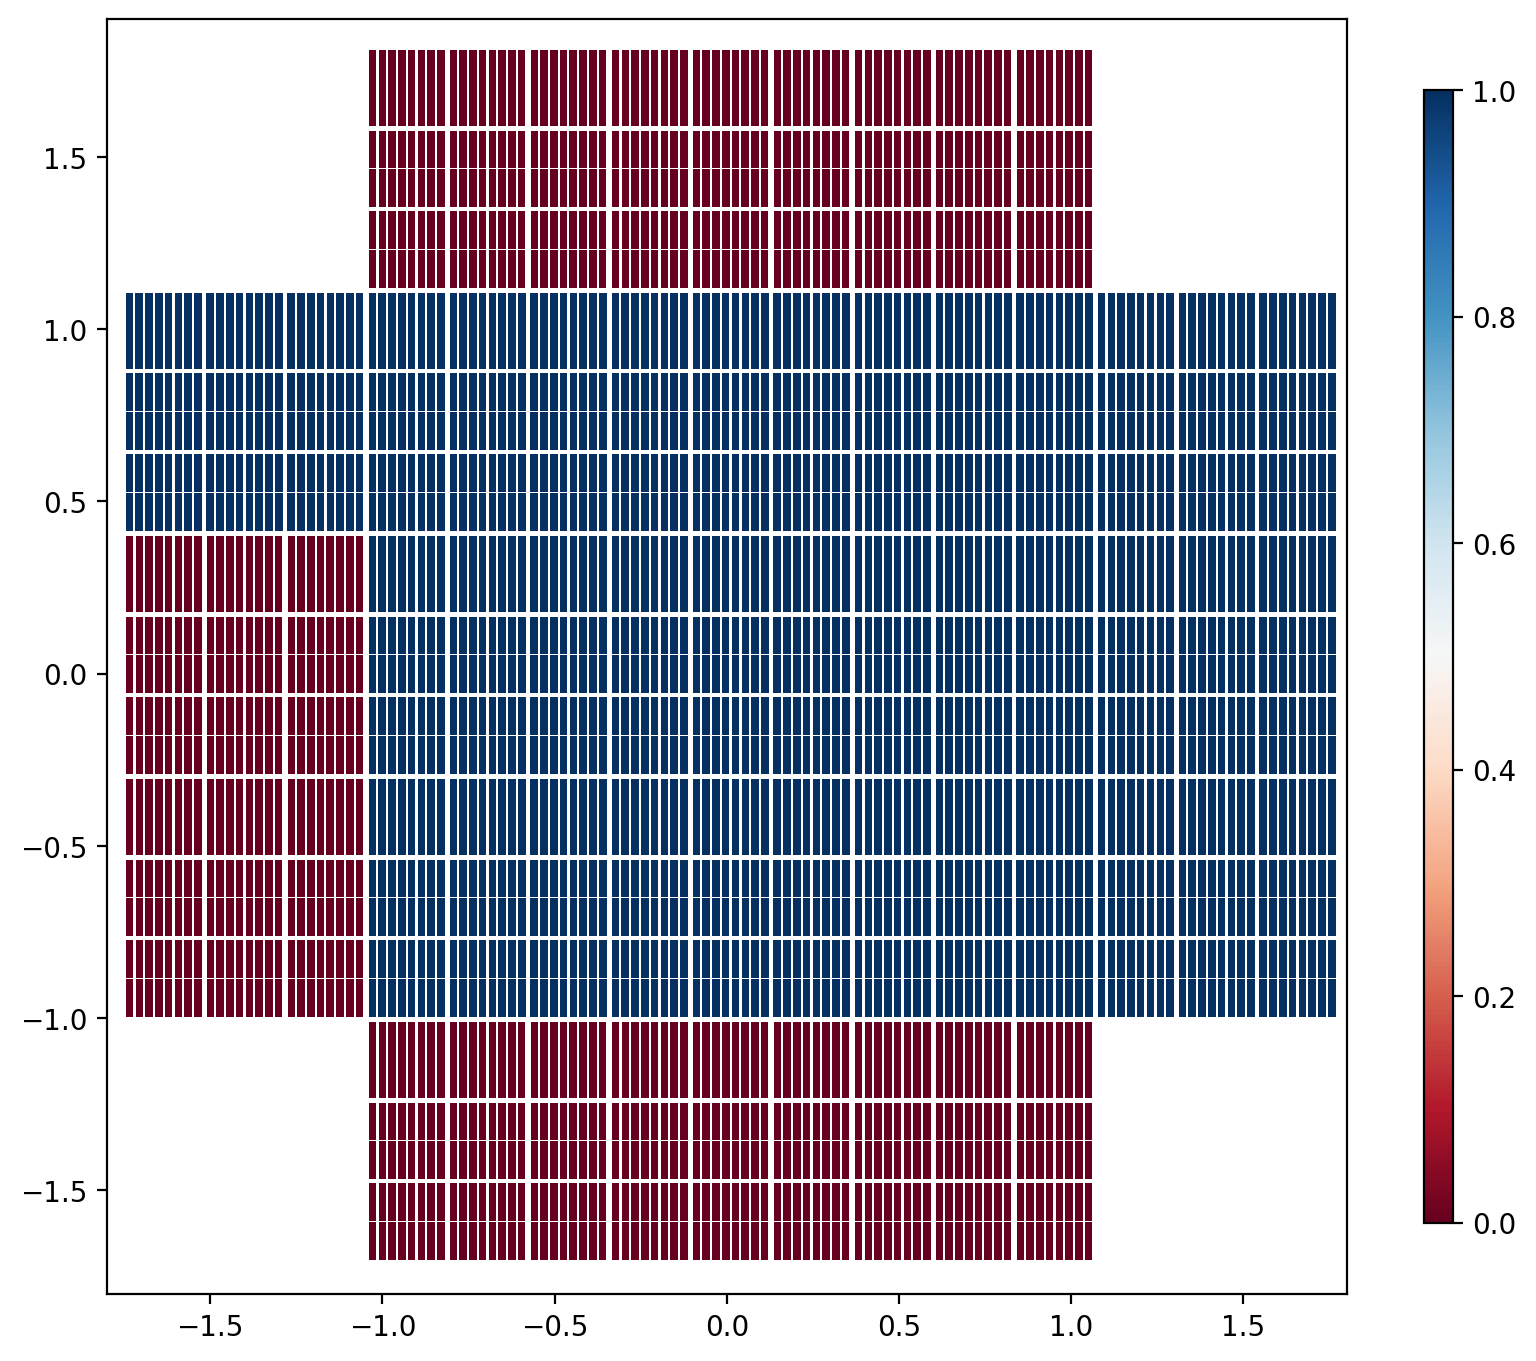

In [30]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.set_aspect('equal')
patches = []
v = []
for det in raDeg:
    for amp in raDeg[det]:
        if vendors[det] == 'itl':
            v.append(0)
        if vendors[det] == 'e2v':
            v.append(1)
        patches.append(Rectangle([raDeg[det][amp], decDeg[det][amp]], 0.022, 0.11))
pc=PatchCollection(patches, edgecolor=None, cmap='RdBu')
pc.set_array(v)
ax.add_collection(pc)
fig.colorbar(pc, shrink=0.75, aspect=40)
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.8, 1.9)
plt.savefig('vendor_focal_plane.png')

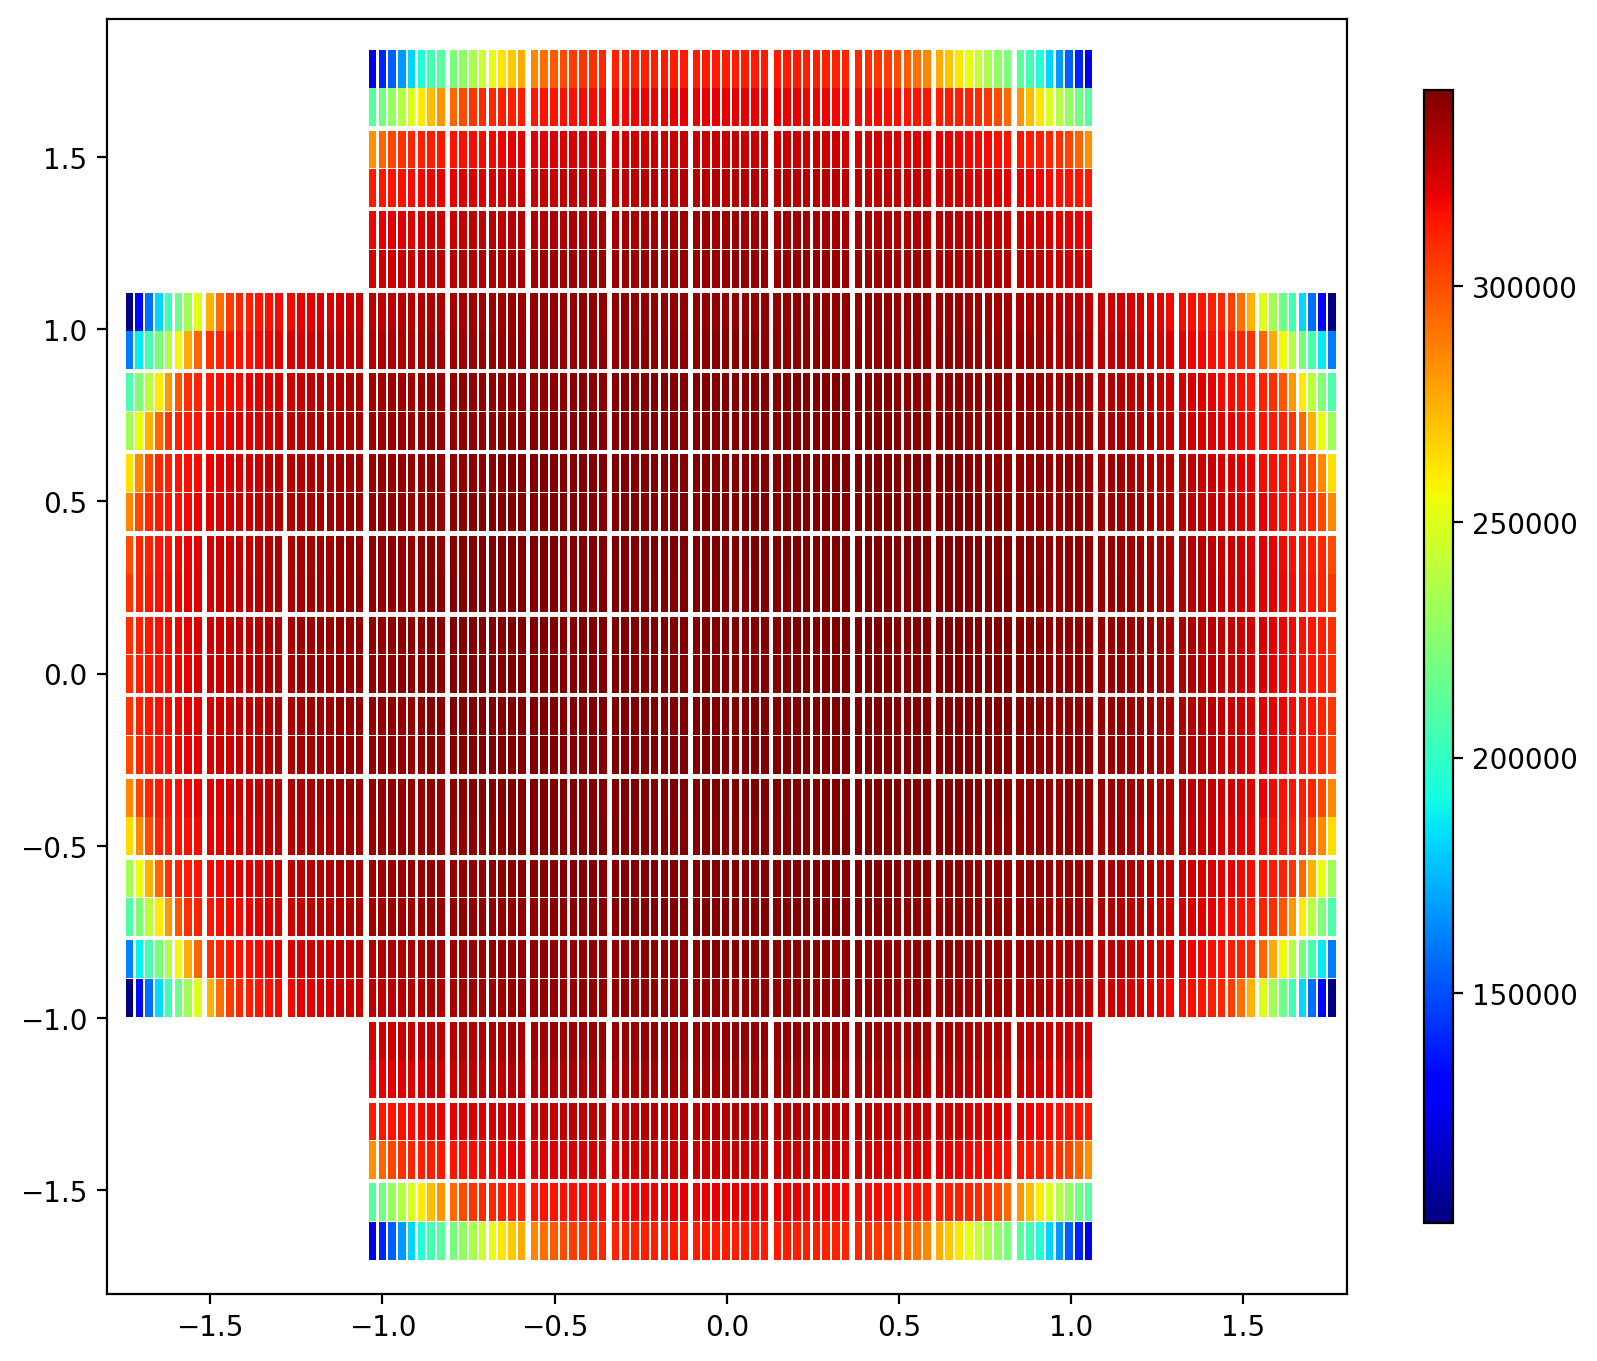

In [31]:
# Vignetting only
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.set_aspect('equal')
patches = []
v = []
for det in raDeg:
    for amp in raDeg[det]:
        effarea = calc_eff_area(radius[det][amp])
        v.append(effarea)
        patches.append(Rectangle([raDeg[det][amp], decDeg[det][amp]], 0.022, 0.11))
pc=PatchCollection(patches, edgecolor=None, cmap='jet')
pc.set_array(v)
ax.add_collection(pc)
fig.colorbar(pc, shrink=0.75, aspect=40)
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.8, 1.9)
plt.savefig('vendor_focal_plane.png')

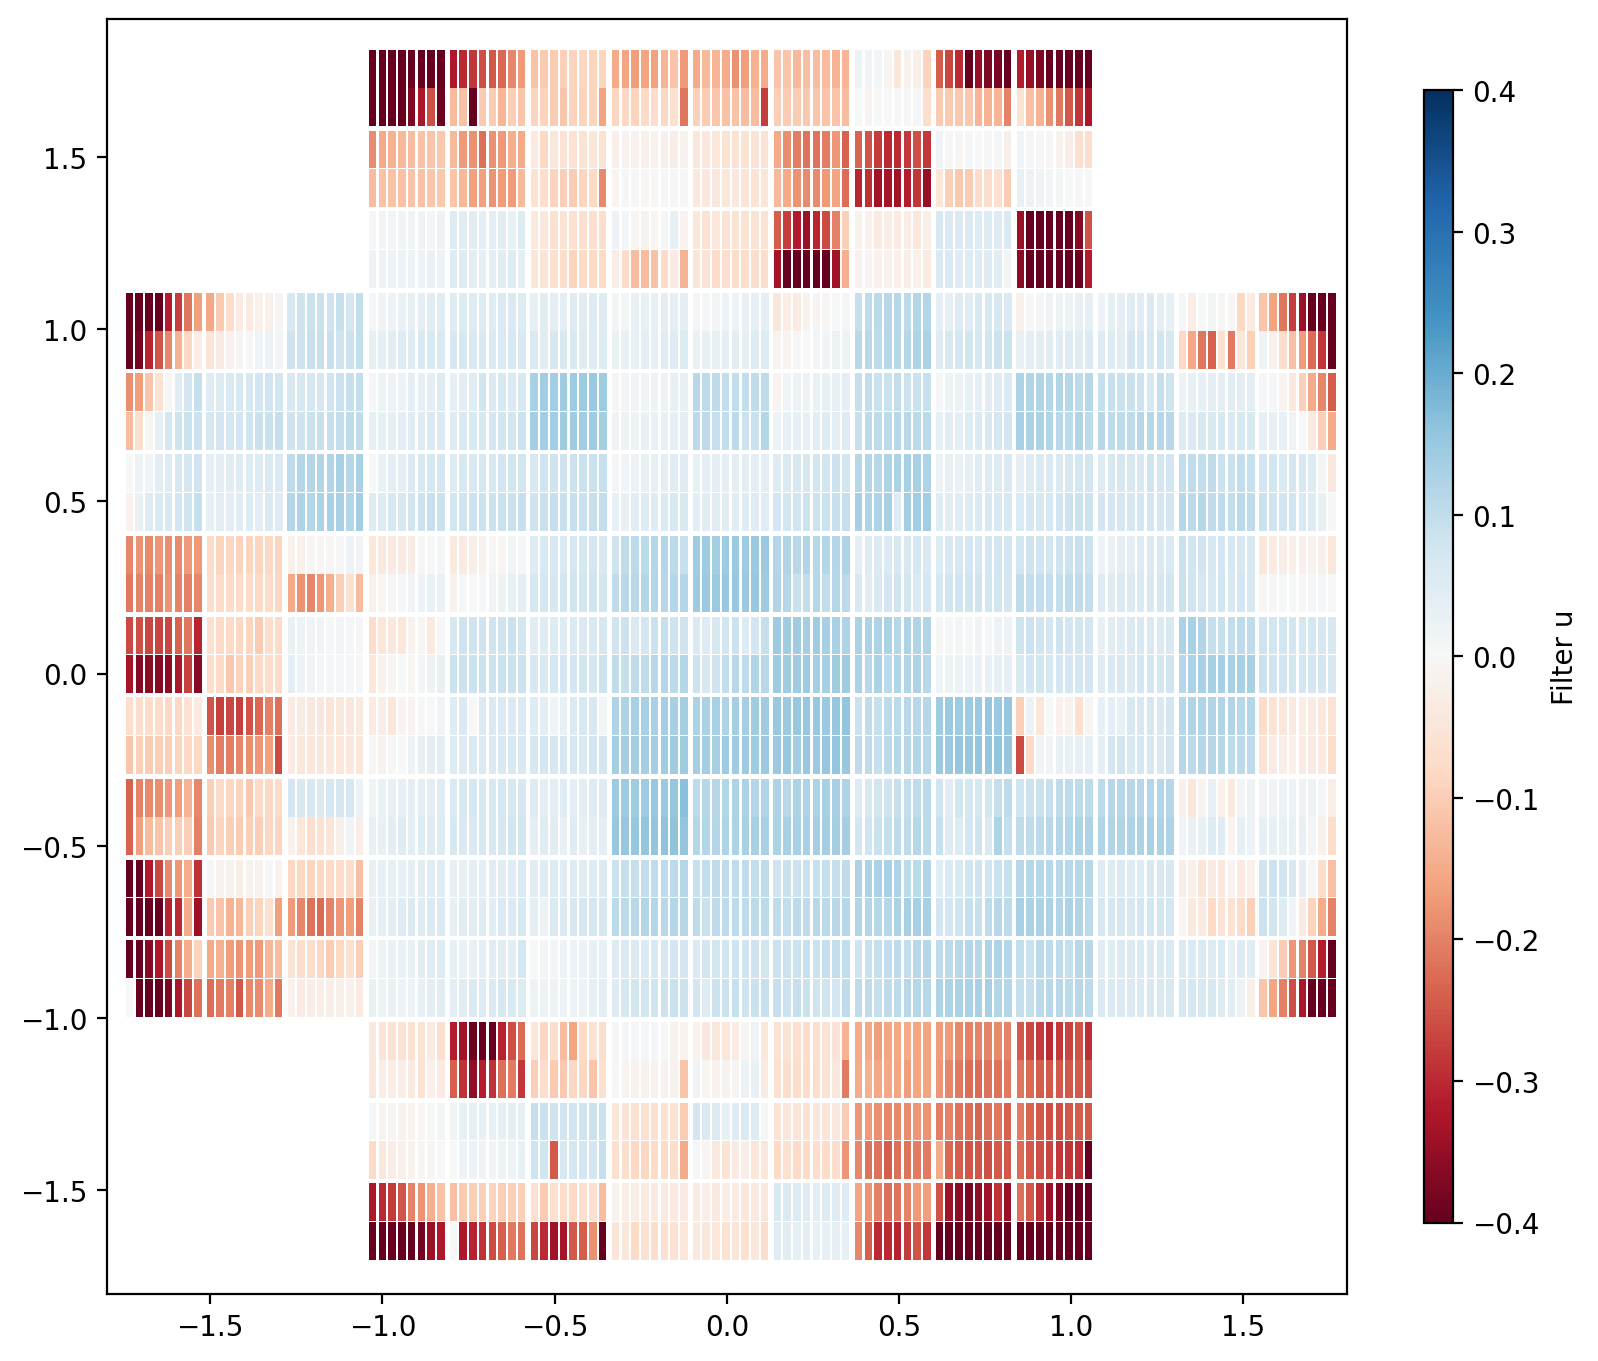

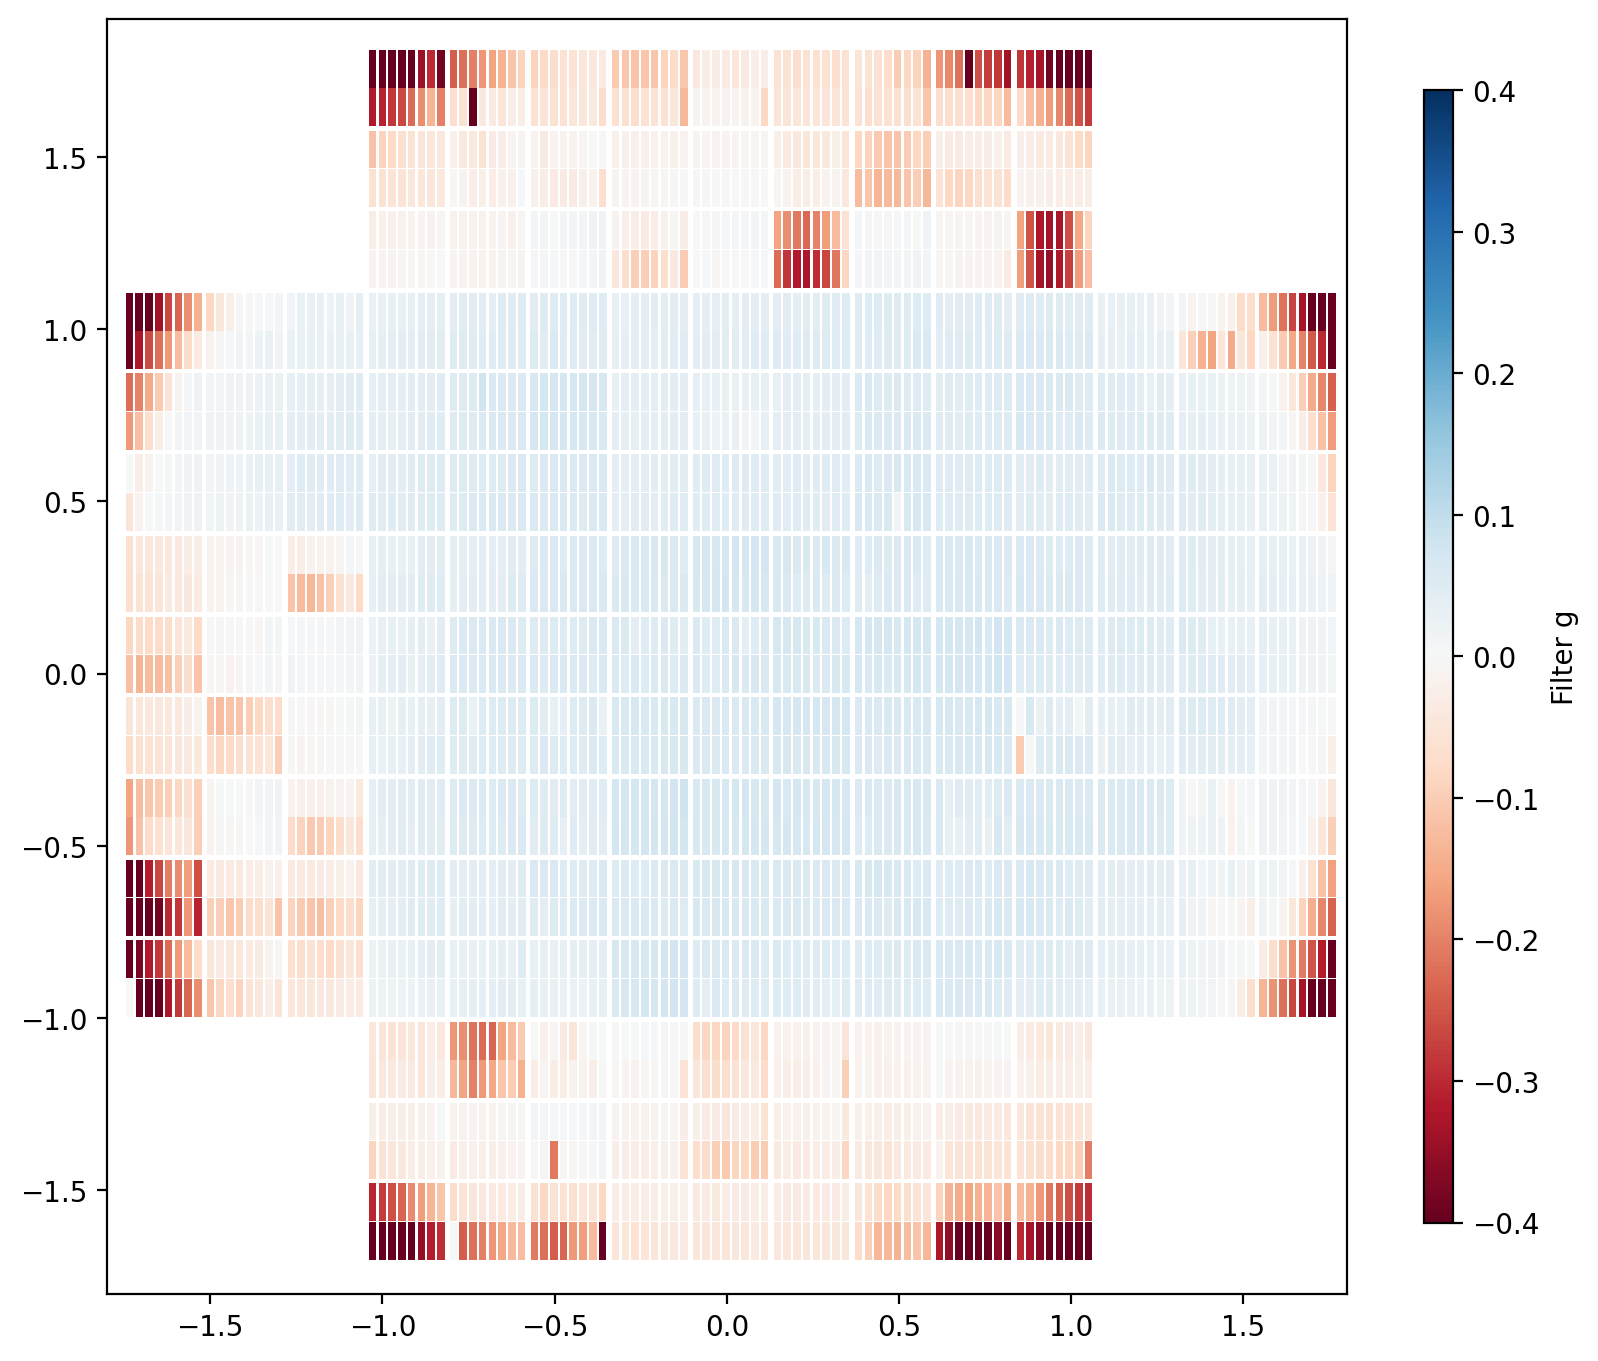

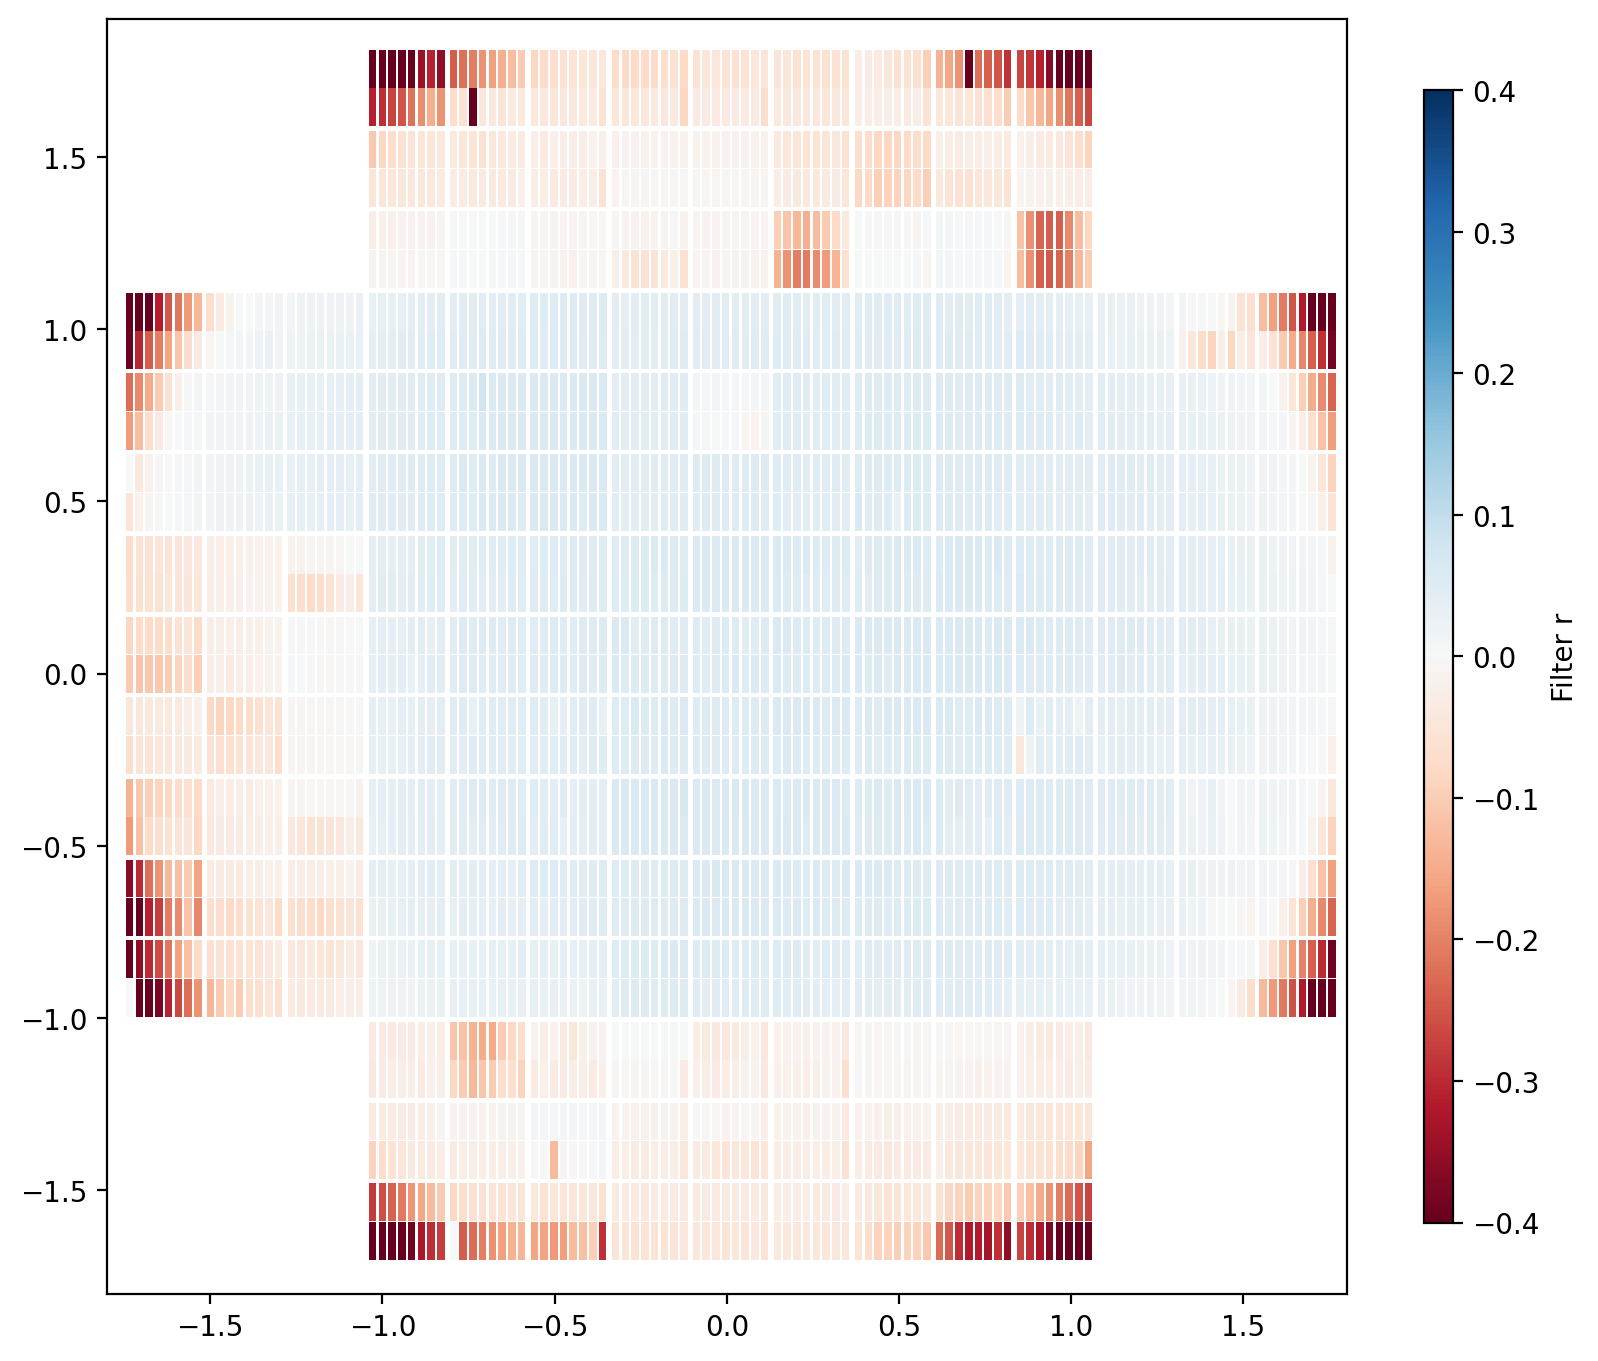

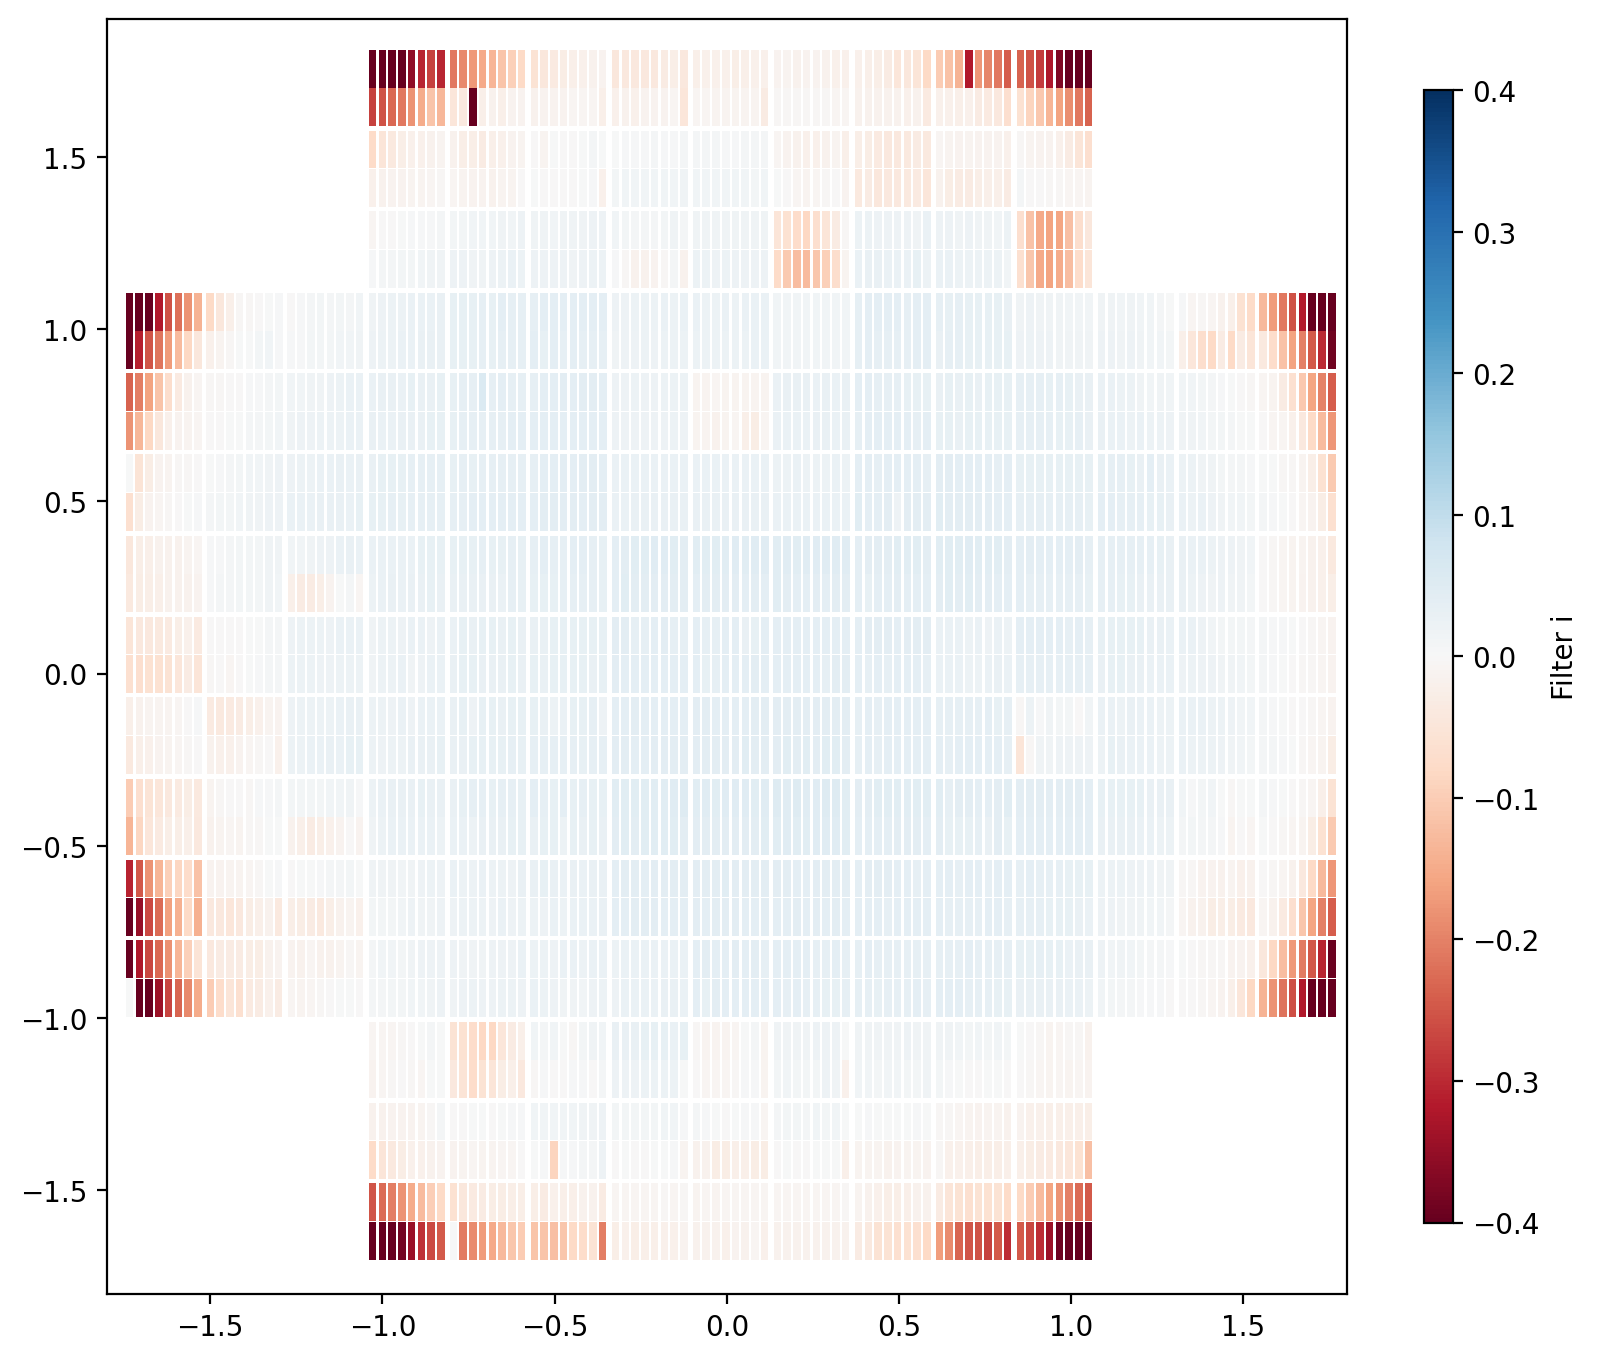

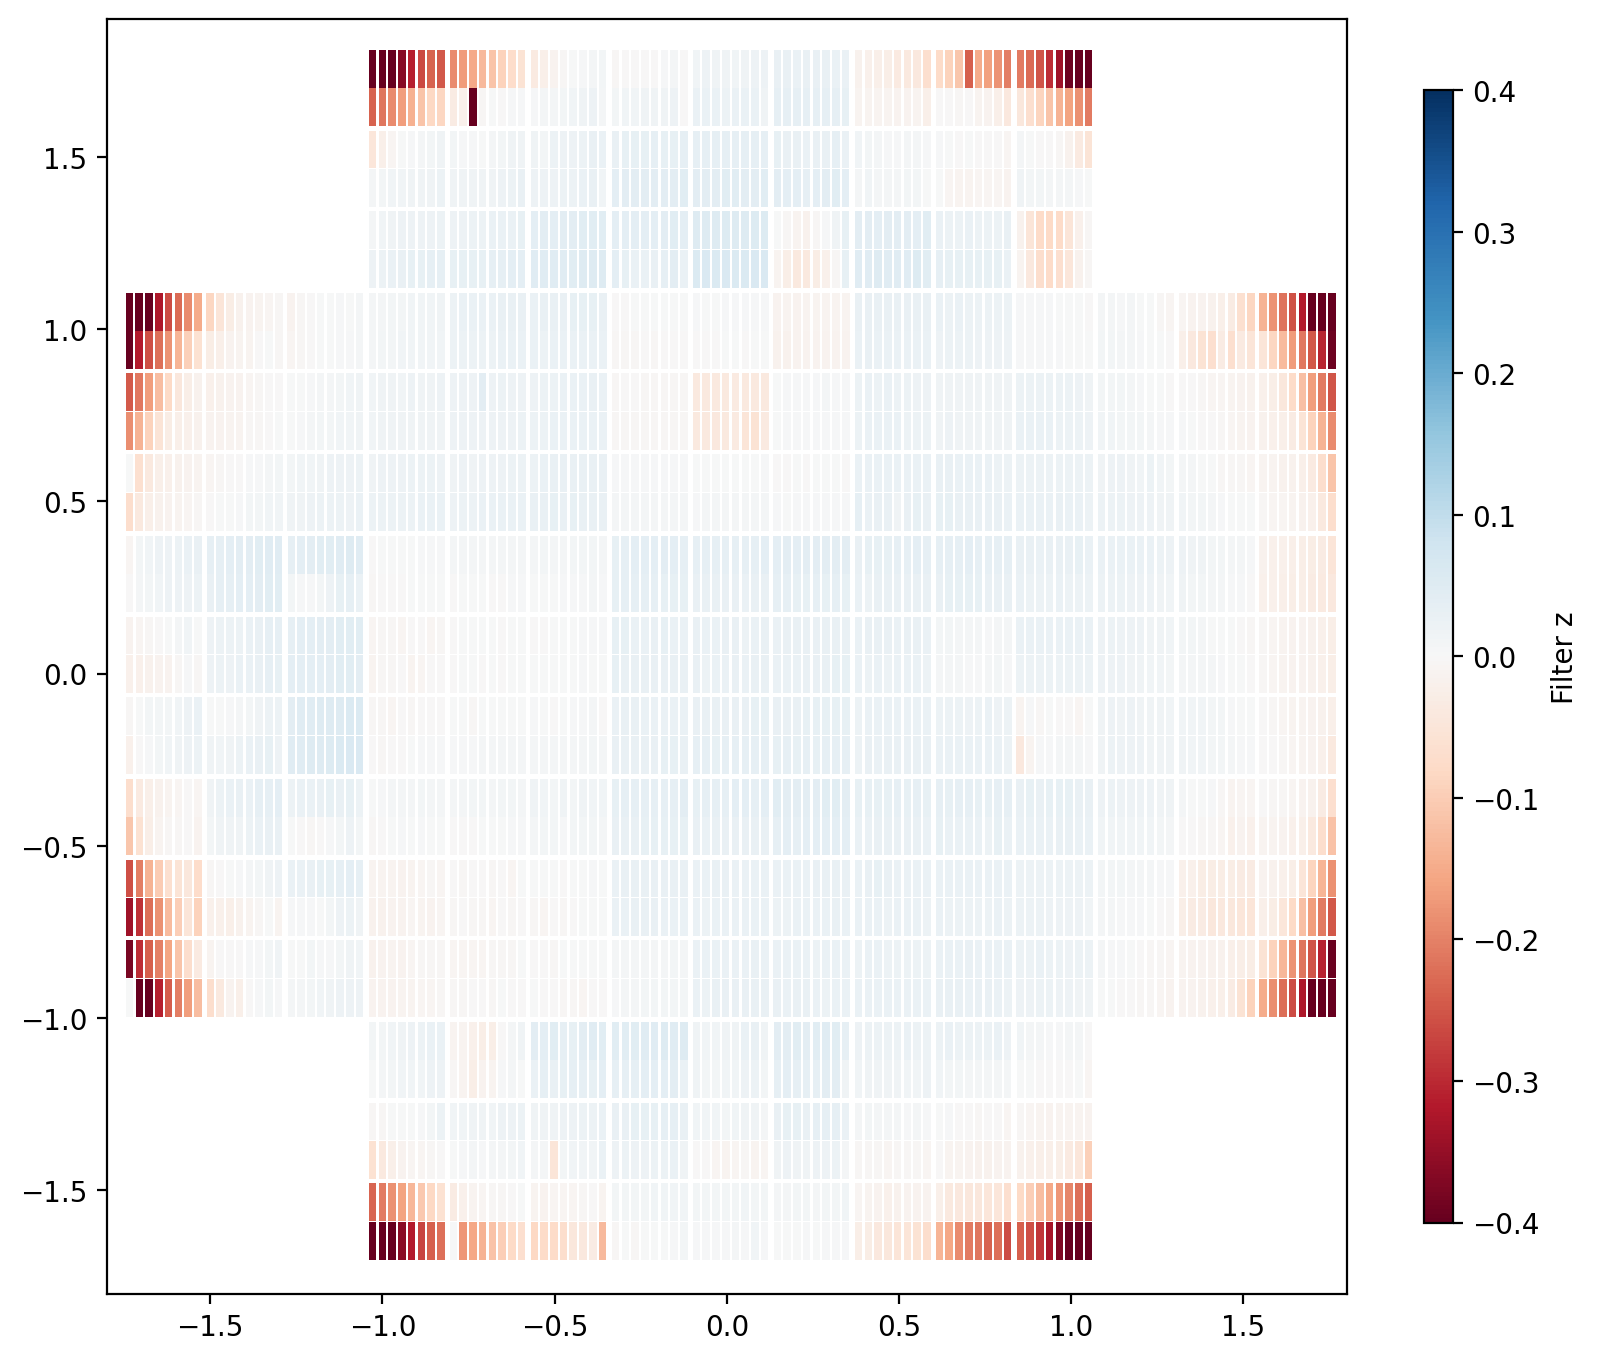

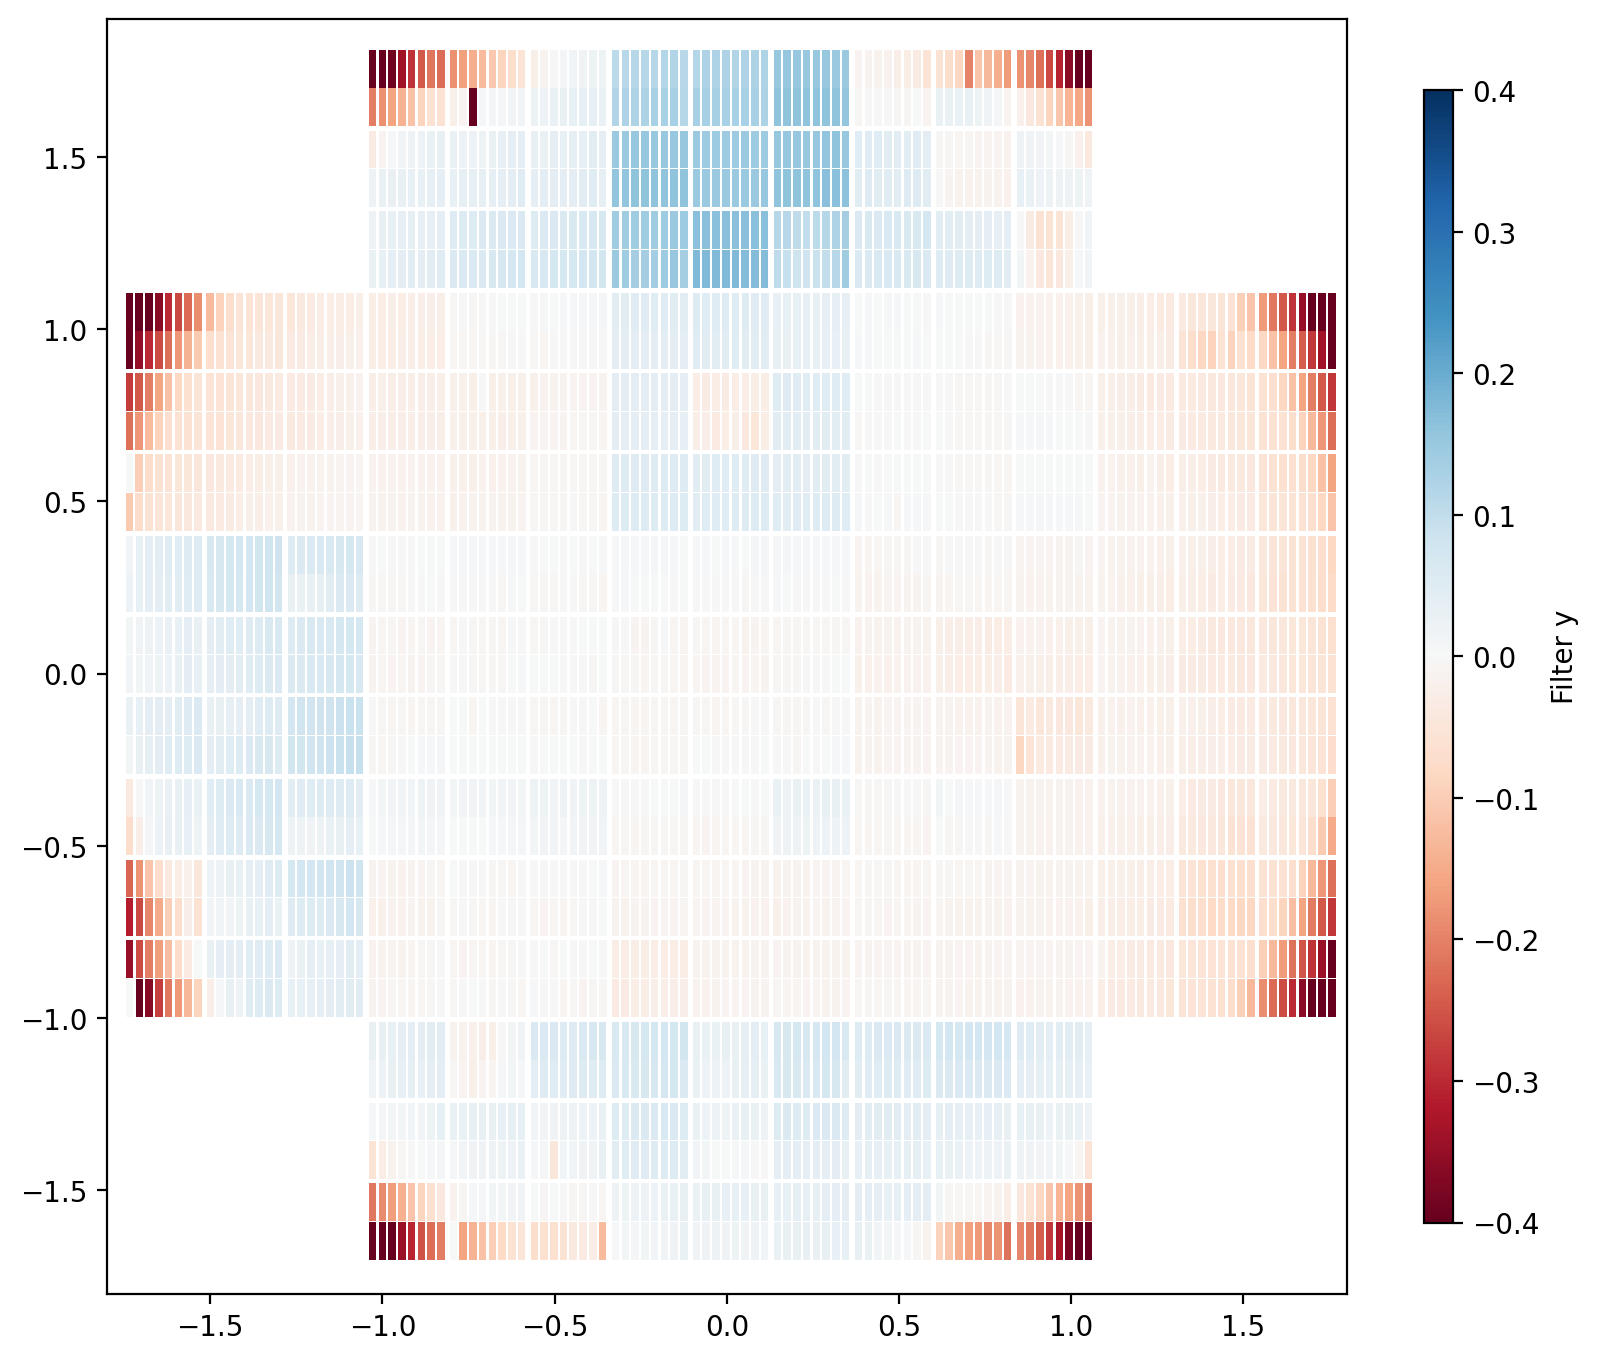

In [34]:
for f in filterlist:
    fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
    ax.set_aspect('equal')
    #zeroval = m5_ref[f]
    zeroval = m5_eff_per_amp[f]
    #zeroval = m5_amp[f]['R22_S22']['C10']
    patches = []
    m5vals = []
    for raftchip in raDeg:
        for amp in raDeg[raftchip]:
            try:
                m5vals.append(m5_amp[f][raftchip][amp] - zeroval)
            except KeyError:
                m5vals.append(0)
            patches.append(Rectangle([raDeg[raftchip][amp], decDeg[raftchip][amp]], 0.022, 0.11))
    pc=PatchCollection(patches, edgecolor=None, cmap='RdBu')
    #pc=PatchCollection(patches, edgecolor=None, cmap='gray')
    pc.set_array(np.array(m5vals))
    pc.set_clim([-0.4, 0.4])
    #pc.set_clim([0.1, -0.6])
    ax.add_collection(pc)
    fig.colorbar(pc, shrink=0.75, aspect=40, label=f'Filter {f}')
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.8, 1.9)
    plt.savefig(f'{f}_focal_plane.png')

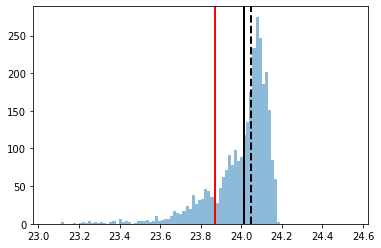

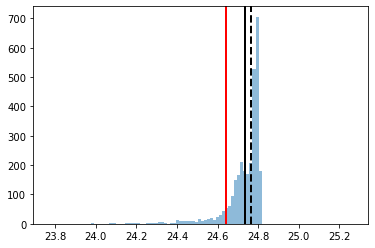

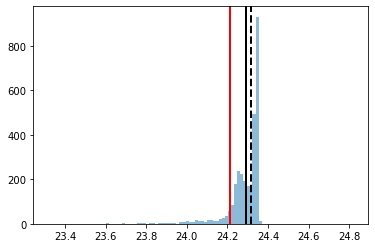

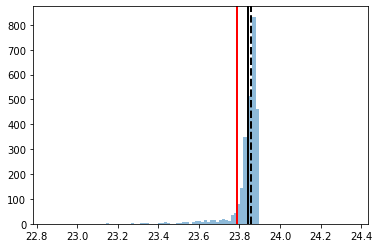

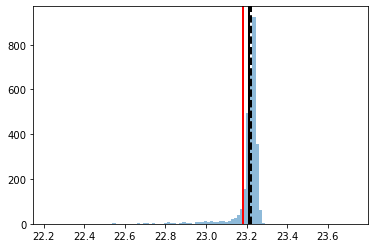

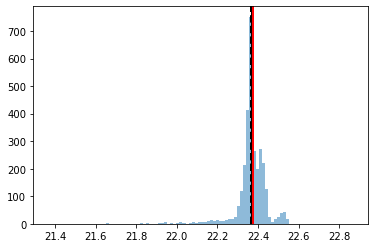

In [33]:
for f in filterlist:
    fig, ax = plt.subplots()
    m5vals = []
    for raftchip in raDeg:
        for amp in raDeg[raftchip]:
            try:
                m5vals.append(m5_amp[f][raftchip][amp])
            except KeyError:
                m5vals.append(0)
    plt.hist(m5vals, bins=100, range=[m5_med_per_amp[f] - 1, m5_med_per_amp[f] + 0.5], alpha=0.5)
    plt.axvline(m5_eff_per_amp[f], color='k', linewidth=2)
    plt.axvline(m5_med_per_amp[f], color='k', linewidth=2, linestyle='--')
    plt.axvline(m5_ref[f], color='r', linewidth=2)
    plt.savefig(f'{f}_focal_plane_hist.png')

In [42]:
# Make a nice table
d = pd.DataFrame([m5_ref, m5_med_per_amp, m5_iqr_per_amp, 
              Cm_ref,  cm_med_per_amp, cm_iqr_per_amp, 
              dCm_inf_ref, dCm_inf_med_per_amp, dCm_inf_iqr_per_amp],
            index=['m5 simulation reference', 'm5 per amp median', 'm5 per amp IQR',
                  'Cm simulation reference', 'Cm per amp median', 'Cm per amp IQR',
                  'dCm_inf reference', 'dCm_inf per amp median', 'dCm_inf per amp IQR'])
d = d[['u', 'g', 'r', 'i', 'z', 'y']]
d.round(2)

u      g      r      i      z      y
m5 simulation reference  23.87  24.64  24.21  23.79  23.18  22.37
m5 per amp median        24.05  24.77  24.32  23.86  23.22  22.37
m5 per amp IQR            0.15   0.08   0.08   0.04   0.03   0.06
Cm simulation reference  23.46  24.45  24.45  24.35  24.19  23.75
Cm per amp median        23.64  24.58  24.56  24.42  24.23  23.75
Cm per amp IQR            0.15   0.08   0.08   0.04   0.03   0.06
dCm_inf reference         0.28   0.15   0.09   0.06   0.04   0.03
dCm_inf per amp median    0.15   0.07   0.04   0.03   0.02   0.02
dCm_inf per amp IQR       0.07   0.03   0.02   0.01   0.01   0.00

In [43]:
print(d.round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      u &      g &      r &      i &      z &      y \\
\midrule
m5 simulation reference &  23.87 &  24.64 &  24.21 &  23.79 &  23.18 &  22.37 \\
m5 per amp median       &  24.05 &  24.77 &  24.32 &  23.86 &  23.22 &  22.37 \\
m5 per amp IQR          &   0.15 &   0.08 &   0.08 &   0.04 &   0.03 &   0.06 \\
Cm simulation reference &  23.46 &  24.45 &  24.45 &  24.35 &  24.19 &  23.75 \\
Cm per amp median       &  23.64 &  24.58 &  24.56 &  24.42 &  24.23 &  23.75 \\
Cm per amp IQR          &   0.15 &   0.08 &   0.08 &   0.04 &   0.03 &   0.06 \\
dCm\_inf reference       &   0.28 &   0.15 &   0.09 &   0.06 &   0.04 &   0.03 \\
dCm\_inf per amp median  &   0.15 &   0.07 &   0.04 &   0.03 &   0.02 &   0.02 \\
dCm\_inf per amp IQR     &   0.07 &   0.03 &   0.02 &   0.01 &   0.01 &   0.00 \\
\bottomrule
\end{tabular}



In [66]:
offsets = d.loc['m5 simulation reference'] - d.loc['m5 per amp median']
simulated_median = pd.Series({'u': 23.62, 'g': 24.38, 'r': 23.92, 'i': 23.34, 'z': 22.70, 'y': 21.97})
print(pd.DataFrame(simulated_median - offsets).round(2).T.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &     u &     g &      r &      i &      z &      y \\
\midrule
0 &  23.8 &  24.5 &  24.03 &  23.41 &  22.74 &  21.96 \\
\bottomrule
\end{tabular}



In [37]:
# Check SRD requirements on scatter
# requirements = for an image representative of the median depth, 
# no more than 15/20% of the 'devices' are bright than than 0.2/0.4 mag from the median depth

# median depth should be opsim median depth, with matching skybrightness, seeing, and airmass
# but these skybrightness, seeing and airmass are not the median conditions of each of these independently, exactly
# (primarily due to non-gaussianity in skybrightness)
# this would also imply we know how to vary the seeing and skybrightness across the FOV at approximately X=1.2

# so, for now at least, just evaluate the variation in m5 across the amps, in these simulation reference conditions

In [38]:
def percent_x(m5s, m5ref, magthresh1 = 0.2, magthresh2 = 0.4):
    # m5s or Cms or dCmInfinitys
    percent1 = {}
    percent2 = {}
    for f in filterlist:
        allvals = []
        for raftchip in m5s[f]:
            allvals += list(m5s[f][raftchip].values())
        allvals = np.array(allvals)
        # Subtract reference value - negative values == brighter limiting mags, positive = fainter
        allvals = allvals - m5ref[f]
        percent1[f] = len(np.where(allvals < -magthresh1)[0])/len(allvals) * 100
        percent2[f] = len(np.where(allvals < -magthresh2)[0])/len(allvals) * 100
    return percent1, percent2

In [39]:
ref = m5_eff_per_amp
perc1, perc2 = percent_x(m5_amp, ref)
pd.DataFrame([perc1, perc2], index=['Percent < 0.2 mag', 'Percent < 0.4 mag'])

u         g         r         i         z         y
Percent < 0.2 mag  11.353856  5.196955  4.237008  3.541874  3.210857  3.045349
Percent < 0.4 mag   2.780536  1.588878  1.059252  0.893744  0.728236  0.728236